In [2]:
import numpy as np
import random
import os
import datetime
import cv2

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import backend as K
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import (Dense, Conv2D, Conv3D, Flatten, TimeDistributed, 
                                    BatchNormalization, GRU, LSTM, Bidirectional,
                                    MaxPooling3D, MaxPooling2D, Input, Dropout,
                                    GlobalAveragePooling2D, GlobalAveragePooling3D,
                                    SeparableConv2D, Concatenate,ConvLSTM2D)
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2

import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
import gc
import keras.backend as K

# Set seeds for reproducibility
np.random.seed(30)
random.seed(30)
tf.random.set_seed(30)

#### This program is run on NVIDIA RTX 3060Ti because of few intermittent issue found in Jarvis AI - could be related to storage, Bandwidth Issues, Time consumption etc
 - It features a compute capability of 8.6, which comes with specific limitations.
 - Models cannot be executed sequentially in a single continuous run.
 - After running a model, please comment it out or restart/close the environment or IDE to free up resources and avoid any resource unavailability issues.
 - The program is designed modularly for each model's computation. Once a model is computed, its summary is printed, and you can proceed to the next model by specifying its index.

 P.S Running local was much better option atleast in this case than depending on cloud GPU. Vultr and Runpod.io is comparitively stable when comapared to JarvisAI

In [2]:
# Define paths and parameters
train_path = './Project_data/train'
val_path = './Project_data/val'
train_doc = np.random.permutation(open('./Project_data/train.csv').readlines())
val_doc = np.random.permutation(open('./Project_data/val.csv').readlines())
batch_size = 2 

In [3]:
# Get current date and time for model naming
curr_dt_time = datetime.datetime.now()

# Print dataset information
num_train_sequences = len(train_doc)
num_val_sequences = len(val_doc)
print('# training sequences =', num_train_sequences)
print('# validation sequences =', num_val_sequences)

# training sequences = 663
# validation sequences = 100


In [4]:
def generator(source_path, folder_list, batch_size, num_frames):
    """
    Yields batches of video data and one-hot labels.
    
    Each folder entry is assumed to be formatted as "folder_name;other_info;label_index".
    """
    # Constants for video processing
    img_height = 112   # target height
    img_width = 112    # target width
    num_classes = 5    # number of classes
    
    # List of frame indices to use for each video folder
    img_idx = list(range(num_frames))
    
    while True:
        t = np.random.permutation(folder_list)
        num_batches = len(t) // batch_size

        # Process full batches
        for batch in range(num_batches):
            batch_data = np.zeros((batch_size, num_frames, img_height, img_width, 3), dtype=np.float32)
            batch_labels = np.zeros((batch_size, num_classes), dtype=np.float32)
            
            for i in range(batch_size):
                # "folder_name;other_info;label_index"
                folder_info = t[i + batch * batch_size].strip().split(';')
                folder_name = folder_info[0]
                label = int(folder_info[2])
                
                folder_path = os.path.join(source_path, folder_name)
                imgs = os.listdir(folder_path)
                imgs.sort()
                
                for idx, item in enumerate(img_idx):
                    if item < len(imgs):  # Handle case when video has fewer frames
                        image_path = os.path.join(folder_path, imgs[item])
                        image = cv2.imread(image_path)
                        if image is None:
                            continue  # Skip if the image is not read properly
                        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                        image = cv2.resize(image, (img_width, img_height))
                        norm_image = image.astype(np.float32) / 255.0
                        batch_data[i, idx, :, :, :] = norm_image
                
                batch_labels[i, label] = 1
            
            yield batch_data, batch_labels
        
        # Process remaining samples (if any)
        remainder = len(t) % batch_size
        if remainder > 0:
            batch_data = np.zeros((remainder, num_frames, img_height, img_width, 3), dtype=np.float32)
            batch_labels = np.zeros((remainder, num_classes), dtype=np.float32)
            
            for i in range(remainder):
                folder_info = t[i + num_batches * batch_size].strip().split(';')
                folder_name = folder_info[0]
                label = int(folder_info[2])
                
                folder_path = os.path.join(source_path, folder_name)
                imgs = os.listdir(folder_path)
                imgs.sort()
                
                for idx, item in enumerate(img_idx):
                    if item < len(imgs):  # Handle case when video has fewer frames
                        image_path = os.path.join(folder_path, imgs[item])
                        image = cv2.imread(image_path)
                        if image is None:
                            continue
                        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                        image = cv2.resize(image, (img_width, img_height))
                        norm_image = image.astype(np.float32) / 255.0
                        batch_data[i, idx, :, :, :] = norm_image
                
                batch_labels[i, label] = 1
            
            yield batch_data, batch_labels

In [5]:
def plothistorygraph(history):
    """
    Plots the training and validation accuracy and loss curves.
    """
    # Plot accuracy
    plt.figure(figsize=(10, 6))
    plt.plot(history.history['categorical_accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_categorical_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))
    plt.legend(loc='upper left')
    plt.grid(True)
    plt.show()

    # Plot training & validation loss values
    plt.figure(figsize=(10, 6))
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))
    plt.legend(loc='upper left')
    plt.grid(True)
    plt.show()

In [6]:
def setup_training(model_name, patience=5):
    """
    Sets up directories and callbacks for training.
    """
    # Create model directory if it doesn't exist
    full_model_name = f'{model_name}_{str(curr_dt_time).replace(" ", "").replace(":", "_")}/'
    if not os.path.exists(full_model_name):
        os.mkdir(full_model_name)
    
    # Define filepath for checkpoints
    filepath = full_model_name + "model-{epoch:02d}-{val_categorical_accuracy:.4f}.h5"
    
    # Define callbacks
    checkpoint = ModelCheckpoint(
        filepath, 
        monitor='val_categorical_accuracy', 
        verbose=1, 
        save_best_only=True, 
        save_weights_only=False
    )
    
    lr_reducer = ReduceLROnPlateau(
        monitor='val_loss', 
        factor=0.2, 
        patience=patience-2, 
        verbose=1, 
        mode='auto', 
        min_delta=0.0001, 
        cooldown=0, 
        min_lr=1e-7
    )
    
    early_stopper = EarlyStopping(
        monitor='val_loss', 
        patience=patience, 
        verbose=1, 
        restore_best_weights=True
    )
    
    return [checkpoint, lr_reducer, early_stopper]

In [7]:
def train_model(model, train_generator, val_generator, batch_size, num_epochs=15, model_name="model"):
    """
    Trains the model with the given generators and parameters.
    """
    # Calculate steps
    if (num_train_sequences % batch_size) == 0:
        steps_per_epoch = int(num_train_sequences / batch_size)
    else:
        steps_per_epoch = (num_train_sequences // batch_size) + 1

    if (num_val_sequences % batch_size) == 0:
        validation_steps = int(num_val_sequences / batch_size)
    else:
        validation_steps = (num_val_sequences // batch_size) + 1
    
    # Setup callbacks
    callbacks_list = setup_training(model_name, patience=5)
    
    # Fit the model
    history = model.fit(
        train_generator,
        steps_per_epoch=steps_per_epoch,
        epochs=num_epochs,
        verbose=1,
        callbacks=callbacks_list,
        validation_data=val_generator,
        validation_steps=validation_steps,
        initial_epoch=0
    )
    
    return history

In [8]:
def cleanup_gpu_memory():
    """
    Function to clean up GPU memory between model training runs.
    This helps prevent out-of-memory errors when training multiple deep learning models sequentially.
    """
    # Clear Keras session
    K.clear_session()
    
    # Run garbage collector
    gc.collect()
    
    # Attempt to clear any remaining memory on GPU
    try:
        # For TensorFlow 2.x
        tf.keras.backend.clear_session()
        
        # Optional: manually trigger CUDA memory cleanup for NVIDIA GPUs
        if tf.config.list_physical_devices('GPU'):
            for gpu in tf.config.list_physical_devices('GPU'):
                try:
                    # Set memory growth to manage memory allocation
                    tf.config.experimental.set_memory_growth(gpu, True)
                except:
                    # Ignore if already configured
                    pass
    except Exception as e:
        print(f"Warning during memory cleanup: {e}")
    
    
    print("✓ GPU memory cleaned")

#################################################
# MODEL 1: CNN + LSTM 
#################################################

In [9]:
def build_cnn_lstm_model(num_frames=12, img_height=112, img_width=112, num_classes=5):

    # Input: a sequence of frames
    inputs = Input(shape=(num_frames, img_height, img_width, 3))
    
    # TimeDistributed CNN: apply Conv2D on each frame
    x = TimeDistributed(Conv2D(32, (3, 3), activation='relu', padding='same'))(inputs)
    x = TimeDistributed(MaxPooling2D((2, 2)))(x)
    x = TimeDistributed(BatchNormalization())(x)
    
    x = TimeDistributed(Conv2D(64, (3, 3), activation='relu', padding='same'))(x)
    x = TimeDistributed(MaxPooling2D((2, 2)))(x)
    x = TimeDistributed(BatchNormalization())(x)
    
    x = TimeDistributed(Flatten())(x)
    
    # LSTM to capture temporal dynamics
    x = LSTM(128, return_sequences=False)(x)
    
    # Dense layers for classification
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.5)(x)
    outputs = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs=inputs, outputs=outputs)
    
    # Compile the model
    optimizer = Adam(learning_rate=1e-4)
    model.compile(
        optimizer=optimizer, 
        loss='categorical_crossentropy', 
        metrics=['categorical_accuracy']
    )
    
    return model

#################################################
# MODEL 2: 3D CNN 
#################################################

In [10]:
def build_3dcnn_model(num_frames=12, img_height=112, img_width=112, num_classes=5):

    # Define the input shape
    input_shape = (num_frames, img_height, img_width, 3)
    
    model = Sequential()
    model.add(Input(shape=input_shape))

    # 1st convolutional block
    model.add(Conv3D(32, kernel_size=(3, 3, 3), activation='relu', padding='same'))
    model.add(MaxPooling3D(pool_size=(1, 2, 2), padding='same'))
    model.add(BatchNormalization())

    # 2nd convolutional block
    model.add(Conv3D(64, kernel_size=(3, 3, 3), activation='relu', padding='same'))
    model.add(MaxPooling3D(pool_size=(2, 2, 2), padding='same'))
    model.add(BatchNormalization())

    # 3rd convolutional block
    model.add(Conv3D(128, kernel_size=(3, 3, 3), activation='relu', padding='same'))
    model.add(MaxPooling3D(pool_size=(2, 2, 2), padding='same'))
    model.add(BatchNormalization())

    # Flatten and fully connected layers
    model.add(Flatten())
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.5))

    # Final classification layer
    model.add(Dense(num_classes, activation='softmax'))

    # Compile the model
    model.compile(
        loss='categorical_crossentropy', 
        optimizer=Adam(learning_rate=1e-4), 
        metrics=['categorical_accuracy']
    )
    
    return model

#################################################
# MODEL 3: GRU MODEL
#################################################

In [11]:
def build_cnn_gru_model(num_frames=12, img_height=112, img_width=112, num_classes=5):

    # Input: a sequence of frames
    inputs = Input(shape=(num_frames, img_height, img_width, 3))
    
    # TimeDistributed CNN: apply Conv2D on each frame
    x = TimeDistributed(Conv2D(32, (3, 3), activation='relu', padding='same'))(inputs)
    x = TimeDistributed(MaxPooling2D((2, 2)))(x)
    x = TimeDistributed(BatchNormalization())(x)
    
    x = TimeDistributed(Conv2D(64, (3, 3), activation='relu', padding='same'))(x)
    x = TimeDistributed(MaxPooling2D((2, 2)))(x)
    x = TimeDistributed(BatchNormalization())(x)
    
    x = TimeDistributed(Flatten())(x)
    
    # GRU to capture temporal dynamics
    x = GRU(128, return_sequences=False)(x)
    
    # Dense layers for classification
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.5)(x)
    outputs = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs=inputs, outputs=outputs)
    
    # Compile the model
    optimizer = Adam(learning_rate=1e-4)
    model.compile(
        optimizer=optimizer, 
        loss='categorical_crossentropy', 
        metrics=['categorical_accuracy']
    )
    
    return model

#################################################
# MODEL 4: BIDIRECTIONAL LSTM MODEL
#################################################

In [12]:
def build_bidirectional_lstm_model(num_frames=12, img_height=112, img_width=112, num_classes=5):

    # Create model with clear input shape
    inputs = Input(shape=(num_frames, img_height, img_width, 3))

    # CNN feature extraction with TimeDistributed
    x = TimeDistributed(Conv2D(32, (3, 3), activation='relu', padding='same'))(inputs)
    x = TimeDistributed(MaxPooling2D((2, 2)))(x)
    x = TimeDistributed(BatchNormalization())(x)

    x = TimeDistributed(Conv2D(64, (3, 3), activation='relu', padding='same'))(x)
    x = TimeDistributed(MaxPooling2D((2, 2)))(x)
    x = TimeDistributed(BatchNormalization())(x)

    # Flatten CNN output for each time step before feeding to RNN
    x = TimeDistributed(Flatten())(x)

    # Bidirectional LSTM layers - reduced size to fit on GPU
    x = Bidirectional(LSTM(64, return_sequences=True))(x)
    x = Bidirectional(LSTM(32, return_sequences=False))(x)

    # Dense layers for classification with dropout for regularization
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.5)(x)
    outputs = Dense(num_classes, activation='softmax')(x)

    # Create and compile the model
    model = Model(inputs=inputs, outputs=outputs)
    optimizer = Adam(learning_rate=1e-4)
    model.compile(
        optimizer=optimizer, 
        loss='categorical_crossentropy', 
        metrics=['categorical_accuracy']
    )
    
    return model

#################################################
# MODEL 5: BIDIRECTIONAL GRU MODEL
#################################################

In [13]:
def build_bidirectional_gru_model(num_frames=12, img_height=112, img_width=112, num_classes=5):
 
    # Create model with clear input shape
    inputs = Input(shape=(num_frames, img_height, img_width, 3))

    # CNN feature extraction with TimeDistributed
    x = TimeDistributed(Conv2D(32, (3, 3), activation='relu', padding='same'))(inputs)
    x = TimeDistributed(MaxPooling2D((2, 2)))(x)
    x = TimeDistributed(BatchNormalization())(x)

    x = TimeDistributed(Conv2D(64, (3, 3), activation='relu', padding='same'))(x)
    x = TimeDistributed(MaxPooling2D((2, 2)))(x)
    x = TimeDistributed(BatchNormalization())(x)

    # Flatten CNN output for each time step before feeding to RNN
    x = TimeDistributed(Flatten())(x)

    # Bidirectional GRU layers - reduced size for GPU
    x = Bidirectional(GRU(64, return_sequences=True))(x)
    x = Bidirectional(GRU(32, return_sequences=False))(x)

    # Dense layers for classification with dropout for regularization
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.5)(x)
    outputs = Dense(num_classes, activation='softmax')(x)

    # Create and compile the model
    model = Model(inputs=inputs, outputs=outputs)
    optimizer = Adam(learning_rate=1e-4)
    model.compile(
        optimizer=optimizer, 
        loss='categorical_crossentropy', 
        metrics=['categorical_accuracy']
    )
    
    return model

#################################################
# MODEL 6: PARALLEL CNN-RNN ARCHITECTURE
#################################################

In [14]:
def build_parallel_cnn_rnn_model(num_frames=10, img_height=112, img_width=112, num_classes=5):
 
    # Input shape
    inputs = Input(shape=(num_frames, img_height, img_width, 3))
    
    # Path 1: 3D CNN for spatiotemporal features
    path1 = Conv3D(32, kernel_size=(3, 3, 3), activation='relu', padding='same')(inputs)
    path1 = MaxPooling3D(pool_size=(1, 2, 2))(path1)
    path1 = BatchNormalization()(path1)
    
    path1 = Conv3D(64, kernel_size=(3, 3, 3), activation='relu', padding='same')(path1)
    path1 = MaxPooling3D(pool_size=(1, 2, 2))(path1)
    path1 = GlobalAveragePooling3D()(path1)
    
    # Path 2: CNN + GRU for separate spatial-temporal processing
    path2 = TimeDistributed(Conv2D(32, (3, 3), activation='relu', padding='same'))(inputs)
    path2 = TimeDistributed(MaxPooling2D((2, 2)))(path2)
    path2 = TimeDistributed(BatchNormalization())(path2)
    
    path2 = TimeDistributed(GlobalAveragePooling2D())(path2)
    path2 = GRU(64, return_sequences=False)(path2)
    
    # Merge the two paths
    merged = Concatenate()([path1, path2])
    
    # Final classification layers
    x = Dense(128, activation='relu')(merged)
    x = Dropout(0.5)(x)
    outputs = Dense(num_classes, activation='softmax')(x)
    
    # Create and compile the model
    model = Model(inputs=inputs, outputs=outputs)
    
    optimizer = Adam(learning_rate=1e-4)
    model.compile(
        optimizer=optimizer,
        loss='categorical_crossentropy',
        metrics=['categorical_accuracy']
    )
    
    return model

#################################################
# MODEL 7: CONV LSTM MODEL
#################################################

In [15]:
def build_conv_lstm_model(num_frames=10, img_height=112, img_width=112, num_classes=5):

    # Input shape
    inputs = Input(shape=(num_frames, img_height, img_width, 3))
    
    # First ConvLSTM2D layer with downsampling
    x = ConvLSTM2D(16, kernel_size=(3, 3), padding='same', return_sequences=True)(inputs)
    x = BatchNormalization()(x)
    x = MaxPooling3D(pool_size=(1, 2, 2))(x)
    
    # Second ConvLSTM2D layer
    x = ConvLSTM2D(32, kernel_size=(3, 3), padding='same', return_sequences=False)(x)
    x = BatchNormalization()(x)
    
    # Global average pooling to reduce spatial dimensions
    x = GlobalAveragePooling2D()(x)
    
    # Dense layers for classification
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.5)(x)
    outputs = Dense(num_classes, activation='softmax')(x)
    
    # Create and compile the model
    model = Model(inputs=inputs, outputs=outputs)
    
    optimizer = Adam(learning_rate=1e-4)
    model.compile(
        optimizer=optimizer,
        loss='categorical_crossentropy',
        metrics=['categorical_accuracy']
    )
    
    return model

#################################################
# MODEL 8: SEPARABLE CNN + GRU MODEL
#################################################

In [16]:
def build_separable_cnn_gru_model(num_frames=12, img_height=112, img_width=112, num_classes=5):
  
    # Input shape
    inputs = Input(shape=(num_frames, img_height, img_width, 3))
    
    # First block: Separable Convolution (more efficient than standard Conv2D)
    x = TimeDistributed(SeparableConv2D(32, (3, 3), activation='relu', padding='same'))(inputs)
    x = TimeDistributed(MaxPooling2D((2, 2)))(x)
    x = TimeDistributed(BatchNormalization())(x)
    
    # Second block: Separable Convolution
    x = TimeDistributed(SeparableConv2D(64, (3, 3), activation='relu', padding='same'))(x)
    x = TimeDistributed(MaxPooling2D((2, 2)))(x)
    x = TimeDistributed(BatchNormalization())(x)
    
    # Use global average pooling instead of flattening
    x = TimeDistributed(GlobalAveragePooling2D())(x)
    
    # GRU layers with modest capacity
    x = GRU(128, return_sequences=False, dropout=0.3)(x)
    
    # Dense layers with regularization
    x = Dense(128, activation='relu', kernel_regularizer=l2(0.001))(x)
    x = Dropout(0.5)(x)
    outputs = Dense(num_classes, activation='softmax')(x)
    
    # Create and compile the model
    model = Model(inputs=inputs, outputs=outputs)
    
    optimizer = Adam(learning_rate=1e-4)
    model.compile(
        optimizer=optimizer,
        loss='categorical_crossentropy',
        metrics=['categorical_accuracy']
    )
    
    return model

#################################################
# MODEL 9: 3D CNN V2
#################################################

In [17]:
def build_cnn_gru_model_v2(num_frames=12, img_height=112, img_width=112, num_classes=5, weight_decay=1e-4):
    """
    CNN+GRU model with fewer frames for GPU compatibility, incorporating L2 regularization,
    increased dropout,number of epochs and batch normalization.
    """
    inputs = Input(shape=(num_frames, img_height, img_width, 3))
    
    # TimeDistributed CNN with L2 regularization on Conv2D layers
    x = TimeDistributed(Conv2D(32, (3, 3), activation='relu', padding='same', 
                               kernel_regularizer=l2(weight_decay)))(inputs)
    x = TimeDistributed(MaxPooling2D((2, 2)))(x)
    x = TimeDistributed(BatchNormalization())(x)
    
    x = TimeDistributed(Conv2D(64, (3, 3), activation='relu', padding='same', 
                               kernel_regularizer=l2(weight_decay)))(x)
    x = TimeDistributed(MaxPooling2D((2, 2)))(x)
    x = TimeDistributed(BatchNormalization())(x)
    
    x = TimeDistributed(Flatten())(x)
    
    # GRU layer with L2 regularization to capture temporal dynamics
    x = GRU(128, return_sequences=False, kernel_regularizer=l2(weight_decay))(x)
    
    # Dense layers for classification with dropout and L2 regularization
    x = Dense(256, activation='relu', kernel_regularizer=l2(weight_decay))(x)
    x = Dropout(0.6)(x)  # Increased dropout to help prevent overfitting
    outputs = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs=inputs, outputs=outputs)
    
    optimizer = Adam(learning_rate=1e-4)
    model.compile(
        optimizer=optimizer, 
        loss='categorical_crossentropy', 
        metrics=['categorical_accuracy']
    )
    
    return model

In [18]:
batch_size = 2

In [19]:
model_builders = {
        1: build_cnn_lstm_model,
        2: build_3dcnn_model,
        3: build_cnn_gru_model,
        4: build_bidirectional_lstm_model,
        5: build_bidirectional_gru_model,
        6: build_parallel_cnn_rnn_model,
        7: build_conv_lstm_model,
        8: build_separable_cnn_gru_model,
        9: build_cnn_gru_model_v2
    }
model_frames = {
        1: 12,
        2: 12,
        3: 12,
        4: 12,
        5: 12,
        6: 10,
        7: 10,
        8: 12,
        9: 12
    }

In [20]:
def print_model_results(model_id, history, model_name):
    # Find the epoch with the highest validation accuracy
    cat_acc_list = history.history['categorical_accuracy']
    val_acc_list = history.history['val_categorical_accuracy']
    
    
    # Retrieve metrics from the best epoch
    best_train_acc = max(cat_acc_list)
    best_val_acc = max(val_acc_list)

    # Format header (all strings)
    header_format = "{:<10} {:<30} {:<20} {:<20}"
    header = header_format.format("Model ID", "Model Name", "Training Accuracy", "Validation Accuracy")
    separator = "=" * len(header)

    # Format row (include floating point formatting)
    row_format = "{:<10} {:<30} {:<20.4f} {:<20.4f}"
    row = row_format.format(model_id, model_name, best_train_acc, best_val_acc)

    # Print the formatted table
    print("\n" + separator)
    print(header)
    print(separator)
    print(row)
    print(separator + "\n")


In [21]:
def modelutil(models_to_train, num_epochs=10):
    """
    Train multiple models with memory cleanup between each model.
    
    Parameters:
    -----------
    models_to_train : list
        List of model IDs to train
    
    Returns:
    --------
    dict
        Dictionary containing results for each model
    """
    results = {}
    model_builders = {
        1: build_cnn_lstm_model,
        2: build_3dcnn_model,
        3: build_cnn_gru_model,
        4: build_bidirectional_lstm_model,
        5: build_bidirectional_gru_model,
        6: build_parallel_cnn_rnn_model,
        7: build_conv_lstm_model,
        8: build_separable_cnn_gru_model,
        9: build_cnn_gru_model_v2
        
    }
    
    model_frames = {
        1: 12,
        2: 12,
        3: 12,
        4: 12,
        5: 12,
        6: 10,
        7: 10,
        8: 12,
        9: 12

    }
    
    for model_id in models_to_train:
        # Clean up memory before starting each new model
        cleanup_gpu_memory()
        
        print(f"\n{'='*50}")
        print(f"Training model {model_id} ({model_builders[model_id].__name__})")
        print(f"{'='*50}")
        
        # Get the appropriate model builder and frame count
        model_builder = model_builders[model_id]
        num_frames = model_frames[model_id]
        
        # Build model
        model = model_builder()
        print(f"Model summary for model {model_id} ({model_builders[model_id].__name__}):")
        model.summary()
        
        # Create generators
        train_gen = generator(train_path, train_doc, batch_size, num_frames=num_frames)
        val_gen = generator(val_path, val_doc, batch_size, num_frames=num_frames)
        
        # Train model
        history = train_model(
            model,
            train_gen,
            val_gen,
            batch_size,
            num_epochs=num_epochs,
            model_name=model_builders[model_id].__name__
        )
        
        # Save validation accuracy before cleanup
        val_accuracy = max(history.history['val_categorical_accuracy'])
        
        # Plot results
        plothistorygraph(history)
        
        # Store just the accuracy result, not the whole model or history to save memory
        results[model_id] = {
            'val_accuracy': val_accuracy
        }
       
        print_model_results(model_id, history, model_builders[model_id].__name__)


        # Clean up to prevent memory leaks
        del model
        del history
        del train_gen
        del val_gen
        cleanup_gpu_memory()
           
    return results

✓ GPU memory cleaned

Training model 1 (build_cnn_lstm_model)
Model summary for model 1 (build_cnn_lstm_model):


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 12, 112, 112,   │             0 │
│                                 │ 3)                     │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed                │ (None, 12, 112, 112,   │           896 │
│ (TimeDistributed)               │ 32)                    │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_1              │ (None, 12, 56, 56, 32) │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_2              │ (None, 12, 56, 56, 32) │           128 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_3              │ (None, 12, 56, 56, 64) │        18,496 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_4              │ (None, 12, 28, 28, 64) │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_5              │ (None, 12, 28, 28, 64) │           256 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_6              │ (None, 12, 50176)      │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 128)            │    25,756,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 5)              │         1,285 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 25,810,245 (98.46 MB)

 Trainable params: 25,810,053 (98.46 MB)

 Non-trainable params: 192 (768.00 B)

Epoch 1/10
331/332 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - categorical_accuracy: 0.2947 - loss: 1.6297
Epoch 1: val_categorical_accuracy improved from -inf to 0.44000, saving model to build_cnn_lstm_model_2025-03-3123_20_27.106456/model-01-0.4400.h5


332/332 ━━━━━━━━━━━━━━━━━━━━ 18s 42ms/step - categorical_accuracy: 0.2948 - loss: 1.6293 - val_categorical_accuracy: 0.4400 - val_loss: 1.3926 - learning_rate: 1.0000e-04
Epoch 2/10
331/332 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - categorical_accuracy: 0.4168 - loss: 1.3894
Epoch 2: val_categorical_accuracy improved from 0.44000 to 0.60000, saving model to build_cnn_lstm_model_2025-03-3123_20_27.106456/model-02-0.6000.h5


332/332 ━━━━━━━━━━━━━━━━━━━━ 13s 39ms/step - categorical_accuracy: 0.4168 - loss: 1.3893 - val_categorical_accuracy: 0.6000 - val_loss: 1.2214 - learning_rate: 1.0000e-04
Epoch 3/10
331/332 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - categorical_accuracy: 0.5231 - loss: 1.2050
Epoch 3: val_categorical_accuracy did not improve from 0.60000
332/332 ━━━━━━━━━━━━━━━━━━━━ 13s 38ms/step - categorical_accuracy: 0.5232 - loss: 1.2049 - val_categorical_accuracy: 0.5800 - val_loss: 1.1619 - learning_rate: 1.0000e-04
Epoch 4/10
331/332 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - categorical_accuracy: 0.6668 - loss: 1.0217
Epoch 4: val_categorical_accuracy did not improve from 0.60000
332/332 ━━━━━━━━━━━━━━━━━━━━ 13s 38ms/step - categorical_accuracy: 0.6667 - loss: 1.0217 - val_categorical_accuracy: 0.6000 - val_loss: 1.0233 - learning_rate: 1.0000e-04
Epoch 5/10
331/332 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - categorical_accuracy: 0.7369 - loss: 0.8131
Epoch 5: val_categorical_accuracy improved from 0.60000 to 0.620

332/332 ━━━━━━━━━━━━━━━━━━━━ 13s 39ms/step - categorical_accuracy: 0.7367 - loss: 0.8131 - val_categorical_accuracy: 0.6200 - val_loss: 1.0200 - learning_rate: 1.0000e-04
Epoch 6/10
331/332 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - categorical_accuracy: 0.7919 - loss: 0.6638
Epoch 6: val_categorical_accuracy did not improve from 0.62000
332/332 ━━━━━━━━━━━━━━━━━━━━ 13s 39ms/step - categorical_accuracy: 0.7918 - loss: 0.6638 - val_categorical_accuracy: 0.6100 - val_loss: 0.9141 - learning_rate: 1.0000e-04
Epoch 7/10
331/332 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - categorical_accuracy: 0.8930 - loss: 0.4403
Epoch 7: val_categorical_accuracy did not improve from 0.62000
332/332 ━━━━━━━━━━━━━━━━━━━━ 13s 38ms/step - categorical_accuracy: 0.8929 - loss: 0.4404 - val_categorical_accuracy: 0.6100 - val_loss: 0.9485 - learning_rate: 1.0000e-04
Epoch 8/10
331/332 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - categorical_accuracy: 0.9264 - loss: 0.3474
Epoch 8: val_categorical_accuracy improved from 0.62000 to 0.700

332/332 ━━━━━━━━━━━━━━━━━━━━ 13s 40ms/step - categorical_accuracy: 0.9264 - loss: 0.3474 - val_categorical_accuracy: 0.7000 - val_loss: 0.8741 - learning_rate: 1.0000e-04
Epoch 9/10
331/332 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - categorical_accuracy: 0.9698 - loss: 0.2220
Epoch 9: val_categorical_accuracy did not improve from 0.70000
332/332 ━━━━━━━━━━━━━━━━━━━━ 13s 38ms/step - categorical_accuracy: 0.9698 - loss: 0.2221 - val_categorical_accuracy: 0.6300 - val_loss: 0.9553 - learning_rate: 1.0000e-04
Epoch 10/10
331/332 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - categorical_accuracy: 0.9768 - loss: 0.1353
Epoch 10: val_categorical_accuracy did not improve from 0.70000
332/332 ━━━━━━━━━━━━━━━━━━━━ 13s 38ms/step - categorical_accuracy: 0.9768 - loss: 0.1352 - val_categorical_accuracy: 0.6700 - val_loss: 0.9464 - learning_rate: 1.0000e-04
Restoring model weights from the end of the best epoch: 8.


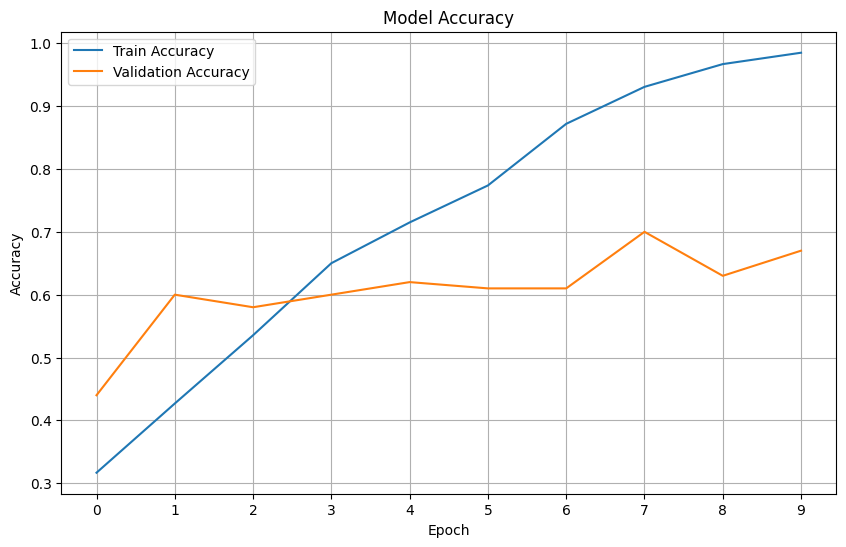

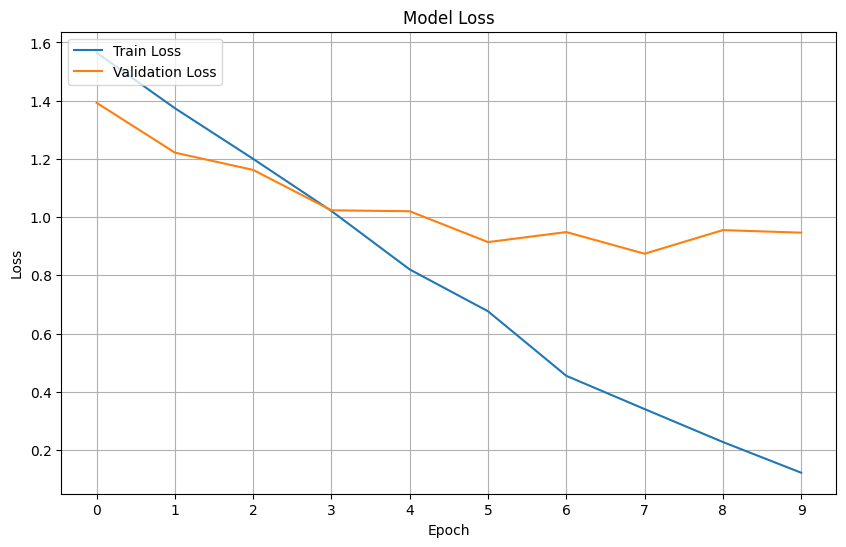


Model ID   Model Name                     Training Accuracy    Validation Accuracy 
1          build_cnn_lstm_model           0.9849               0.7000              

✓ GPU memory cleaned
✓ GPU memory cleaned

Training model 2 (build_3dcnn_model)
Model summary for model 2 (build_3dcnn_model):


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv3d (Conv3D)                 │ (None, 12, 112, 112,   │         2,624 │
│                                 │ 32)                    │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d (MaxPooling3D)    │ (None, 12, 56, 56, 32) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 12, 56, 56, 32) │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_1 (Conv3D)               │ (None, 12, 56, 56, 64) │        55,360 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_1 (MaxPooling3D)  │ (None, 6, 28, 28, 64)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 6, 28, 28, 64)  │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_2 (Conv3D)               │ (None, 6, 28, 28, 128) │       221,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_2 (MaxPooling3D)  │ (None, 3, 14, 14, 128) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 3, 14, 14, 128) │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 75264)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │    19,267,840 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 5)              │         1,285 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 19,549,317 (74.57 MB)

 Trainable params: 19,548,869 (74.57 MB)

 Non-trainable params: 448 (1.75 KB)

Epoch 1/10
332/332 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - categorical_accuracy: 0.2933 - loss: 4.6208
Epoch 1: val_categorical_accuracy improved from -inf to 0.16000, saving model to build_3dcnn_model_2025-03-3123_20_27.106456/model-01-0.1600.h5


332/332 ━━━━━━━━━━━━━━━━━━━━ 15s 36ms/step - categorical_accuracy: 0.2935 - loss: 4.6166 - val_categorical_accuracy: 0.1600 - val_loss: 3.9072 - learning_rate: 1.0000e-04
Epoch 2/10
332/332 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - categorical_accuracy: 0.6473 - loss: 1.1007
Epoch 2: val_categorical_accuracy improved from 0.16000 to 0.61000, saving model to build_3dcnn_model_2025-03-3123_20_27.106456/model-02-0.6100.h5


332/332 ━━━━━━━━━━━━━━━━━━━━ 9s 28ms/step - categorical_accuracy: 0.6472 - loss: 1.1010 - val_categorical_accuracy: 0.6100 - val_loss: 1.1657 - learning_rate: 1.0000e-04
Epoch 3/10
332/332 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - categorical_accuracy: 0.7326 - loss: 0.7401
Epoch 3: val_categorical_accuracy did not improve from 0.61000
332/332 ━━━━━━━━━━━━━━━━━━━━ 9s 26ms/step - categorical_accuracy: 0.7325 - loss: 0.7405 - val_categorical_accuracy: 0.5600 - val_loss: 1.5514 - learning_rate: 1.0000e-04
Epoch 4/10
329/332 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - categorical_accuracy: 0.7234 - loss: 0.8700
Epoch 4: val_categorical_accuracy improved from 0.61000 to 0.63000, saving model to build_3dcnn_model_2025-03-3123_20_27.106456/model-04-0.6300.h5


332/332 ━━━━━━━━━━━━━━━━━━━━ 9s 26ms/step - categorical_accuracy: 0.7235 - loss: 0.8698 - val_categorical_accuracy: 0.6300 - val_loss: 1.1003 - learning_rate: 1.0000e-04
Epoch 5/10
330/332 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - categorical_accuracy: 0.7974 - loss: 0.6268
Epoch 5: val_categorical_accuracy did not improve from 0.63000
332/332 ━━━━━━━━━━━━━━━━━━━━ 8s 25ms/step - categorical_accuracy: 0.7975 - loss: 0.6266 - val_categorical_accuracy: 0.6300 - val_loss: 2.4148 - learning_rate: 1.0000e-04
Epoch 6/10
330/332 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - categorical_accuracy: 0.8437 - loss: 0.4689
Epoch 6: val_categorical_accuracy did not improve from 0.63000
332/332 ━━━━━━━━━━━━━━━━━━━━ 8s 24ms/step - categorical_accuracy: 0.8436 - loss: 0.4699 - val_categorical_accuracy: 0.6300 - val_loss: 1.6389 - learning_rate: 1.0000e-04
Epoch 7/10
328/332 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - categorical_accuracy: 0.8532 - loss: 0.4414
Epoch 7: val_categorical_accuracy improved from 0.63000 to 0.66000,


Epoch 7: ReduceLROnPlateau reducing learning rate to 1.9999999494757503e-05.
332/332 ━━━━━━━━━━━━━━━━━━━━ 8s 23ms/step - categorical_accuracy: 0.8532 - loss: 0.4418 - val_categorical_accuracy: 0.6600 - val_loss: 2.1259 - learning_rate: 1.0000e-04
Epoch 8/10
329/332 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - categorical_accuracy: 0.8956 - loss: 0.3911
Epoch 8: val_categorical_accuracy improved from 0.66000 to 0.73000, saving model to build_3dcnn_model_2025-03-3123_20_27.106456/model-08-0.7300.h5


332/332 ━━━━━━━━━━━━━━━━━━━━ 8s 23ms/step - categorical_accuracy: 0.8958 - loss: 0.3899 - val_categorical_accuracy: 0.7300 - val_loss: 1.3861 - learning_rate: 2.0000e-05
Epoch 9/10
331/332 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - categorical_accuracy: 0.9366 - loss: 0.1584
Epoch 9: val_categorical_accuracy improved from 0.73000 to 0.79000, saving model to build_3dcnn_model_2025-03-3123_20_27.106456/model-09-0.7900.h5


332/332 ━━━━━━━━━━━━━━━━━━━━ 7s 22ms/step - categorical_accuracy: 0.9366 - loss: 0.1584 - val_categorical_accuracy: 0.7900 - val_loss: 1.4528 - learning_rate: 2.0000e-05
Epoch 9: early stopping
Restoring model weights from the end of the best epoch: 4.


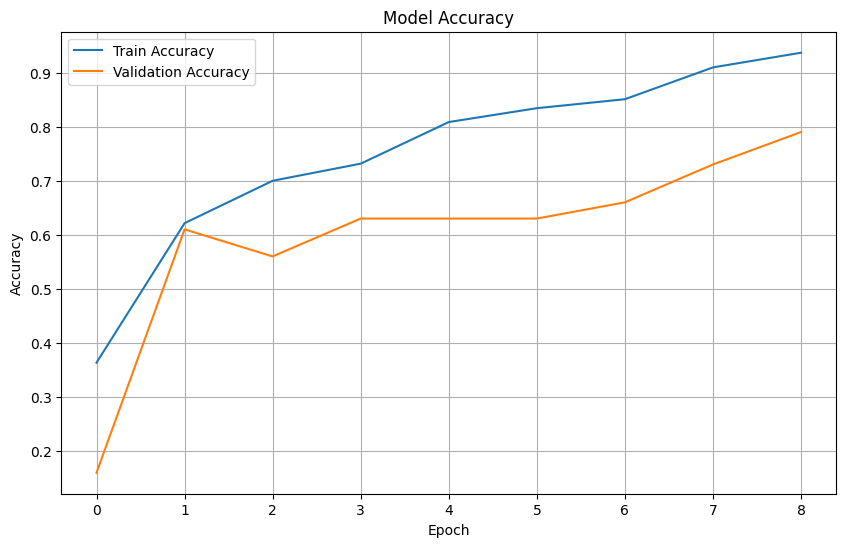

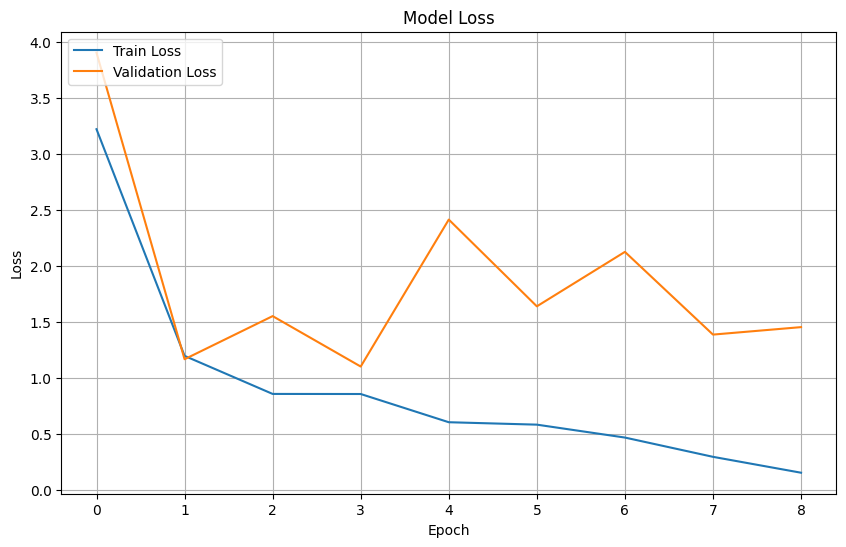


Model ID   Model Name                     Training Accuracy    Validation Accuracy 
2          build_3dcnn_model              0.9367               0.7900              

✓ GPU memory cleaned


In [66]:
models_to_train = [1,2]
all_results = modelutil(models_to_train=models_to_train)


✓ GPU memory cleaned

Training model 3 (build_cnn_gru_model)


I0000 00:00:1743444053.819952   60028 gpu_process_state.cc:208] Using CUDA malloc Async allocator for GPU: 0
I0000 00:00:1743444053.821336   60028 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 5384 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3060 Ti, pci bus id: 0000:2b:00.0, compute capability: 8.6


Model summary for model 3 (build_cnn_gru_model):


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 12, 112, 112,   │             0 │
│                                 │ 3)                     │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed                │ (None, 12, 112, 112,   │           896 │
│ (TimeDistributed)               │ 32)                    │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_1              │ (None, 12, 56, 56, 32) │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_2              │ (None, 12, 56, 56, 32) │           128 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_3              │ (None, 12, 56, 56, 64) │        18,496 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_4              │ (None, 12, 28, 28, 64) │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_5              │ (None, 12, 28, 28, 64) │           256 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_6              │ (None, 12, 50176)      │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru (GRU)                       │ (None, 128)            │    19,317,504 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 5)              │         1,285 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 19,371,589 (73.90 MB)

 Trainable params: 19,371,397 (73.90 MB)

 Non-trainable params: 192 (768.00 B)

Epoch 1/10


I0000 00:00:1743444058.060629   61543 cuda_dnn.cc:529] Loaded cuDNN version 90800


332/332 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - categorical_accuracy: 0.2599 - loss: 1.7255
Epoch 1: val_categorical_accuracy improved from -inf to 0.57000, saving model to build_cnn_gru_model_2025-03-3123_30_11.714341/model-01-0.5700.h5


332/332 ━━━━━━━━━━━━━━━━━━━━ 18s 39ms/step - categorical_accuracy: 0.2600 - loss: 1.7251 - val_categorical_accuracy: 0.5700 - val_loss: 1.2808 - learning_rate: 1.0000e-04
Epoch 2/10
331/332 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - categorical_accuracy: 0.5524 - loss: 1.2383
Epoch 2: val_categorical_accuracy did not improve from 0.57000
332/332 ━━━━━━━━━━━━━━━━━━━━ 12s 36ms/step - categorical_accuracy: 0.5524 - loss: 1.2382 - val_categorical_accuracy: 0.5600 - val_loss: 1.1636 - learning_rate: 1.0000e-04
Epoch 3/10
331/332 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - categorical_accuracy: 0.5941 - loss: 1.0576
Epoch 3: val_categorical_accuracy improved from 0.57000 to 0.61000, saving model to build_cnn_gru_model_2025-03-3123_30_11.714341/model-03-0.6100.h5


332/332 ━━━━━━━━━━━━━━━━━━━━ 12s 36ms/step - categorical_accuracy: 0.5943 - loss: 1.0573 - val_categorical_accuracy: 0.6100 - val_loss: 1.0270 - learning_rate: 1.0000e-04
Epoch 4/10
331/332 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - categorical_accuracy: 0.7235 - loss: 0.7741
Epoch 4: val_categorical_accuracy improved from 0.61000 to 0.65000, saving model to build_cnn_gru_model_2025-03-3123_30_11.714341/model-04-0.6500.h5


332/332 ━━━━━━━━━━━━━━━━━━━━ 12s 37ms/step - categorical_accuracy: 0.7235 - loss: 0.7741 - val_categorical_accuracy: 0.6500 - val_loss: 0.8811 - learning_rate: 1.0000e-04
Epoch 5/10
331/332 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - categorical_accuracy: 0.7902 - loss: 0.6291
Epoch 5: val_categorical_accuracy did not improve from 0.65000
332/332 ━━━━━━━━━━━━━━━━━━━━ 12s 35ms/step - categorical_accuracy: 0.7901 - loss: 0.6292 - val_categorical_accuracy: 0.6500 - val_loss: 0.8806 - learning_rate: 1.0000e-04
Epoch 6/10
331/332 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - categorical_accuracy: 0.8770 - loss: 0.4412
Epoch 6: val_categorical_accuracy did not improve from 0.65000
332/332 ━━━━━━━━━━━━━━━━━━━━ 12s 35ms/step - categorical_accuracy: 0.8769 - loss: 0.4413 - val_categorical_accuracy: 0.6400 - val_loss: 0.9410 - learning_rate: 1.0000e-04
Epoch 7/10
331/332 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - categorical_accuracy: 0.9214 - loss: 0.3273
Epoch 7: val_categorical_accuracy did not improve from 0.65000
3

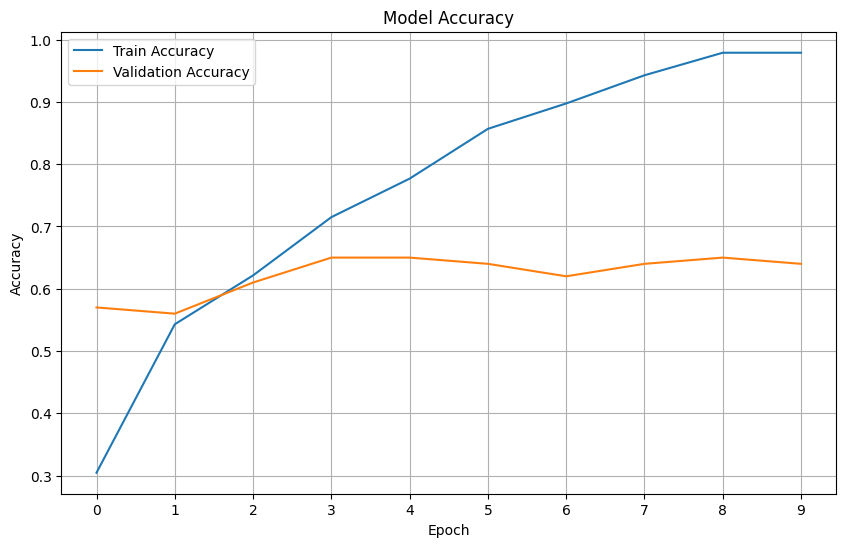

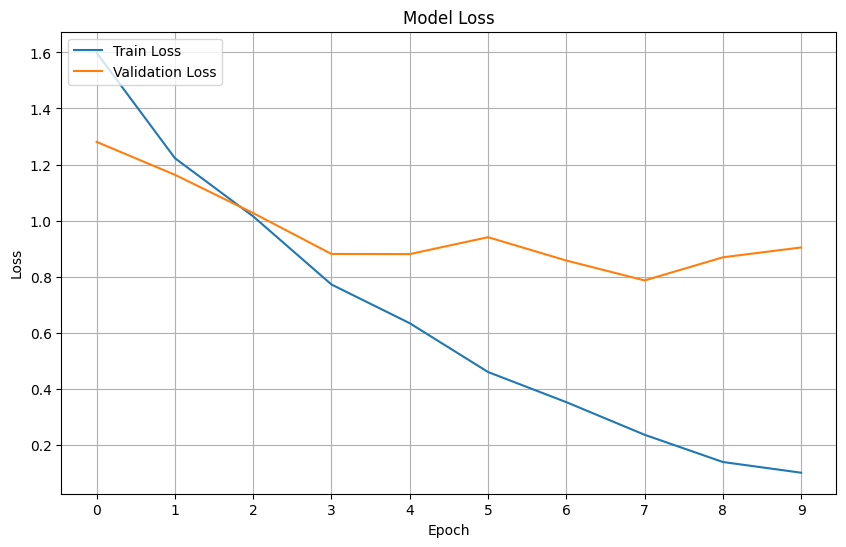


Model ID   Model Name                     Training Accuracy    Validation Accuracy 
3          build_cnn_gru_model            0.9789               0.6500              

✓ GPU memory cleaned


In [23]:
models_to_train = [3]
all_results = modelutil(models_to_train=models_to_train)

✓ GPU memory cleaned

Training model 4 (build_bidirectional_lstm_model)


I0000 00:00:1743444299.954883   63050 gpu_process_state.cc:208] Using CUDA malloc Async allocator for GPU: 0
I0000 00:00:1743444299.956076   63050 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 5337 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3060 Ti, pci bus id: 0000:2b:00.0, compute capability: 8.6


Model summary for model 4 (build_bidirectional_lstm_model):


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 12, 112, 112,   │             0 │
│                                 │ 3)                     │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed                │ (None, 12, 112, 112,   │           896 │
│ (TimeDistributed)               │ 32)                    │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_1              │ (None, 12, 56, 56, 32) │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_2              │ (None, 12, 56, 56, 32) │           128 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_3              │ (None, 12, 56, 56, 64) │        18,496 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_4              │ (None, 12, 28, 28, 64) │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_5              │ (None, 12, 28, 28, 64) │           256 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_6              │ (None, 12, 50176)      │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 12, 128)        │    25,723,392 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, 64)             │        41,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 5)              │           645 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 25,793,349 (98.39 MB)

 Trainable params: 25,793,157 (98.39 MB)

 Non-trainable params: 192 (768.00 B)

Epoch 1/10


I0000 00:00:1743444305.224834   63262 cuda_dnn.cc:529] Loaded cuDNN version 90800


332/332 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - categorical_accuracy: 0.2963 - loss: 1.5589
Epoch 1: val_categorical_accuracy improved from -inf to 0.47000, saving model to build_bidirectional_lstm_model_2025-03-3123_34_05.902621/model-01-0.4700.h5


332/332 ━━━━━━━━━━━━━━━━━━━━ 21s 45ms/step - categorical_accuracy: 0.2964 - loss: 1.5588 - val_categorical_accuracy: 0.4700 - val_loss: 1.4450 - learning_rate: 1.0000e-04
Epoch 2/10
331/332 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - categorical_accuracy: 0.3885 - loss: 1.4180
Epoch 2: val_categorical_accuracy improved from 0.47000 to 0.54000, saving model to build_bidirectional_lstm_model_2025-03-3123_34_05.902621/model-02-0.5400.h5


332/332 ━━━━━━━━━━━━━━━━━━━━ 14s 42ms/step - categorical_accuracy: 0.3887 - loss: 1.4178 - val_categorical_accuracy: 0.5400 - val_loss: 1.2702 - learning_rate: 1.0000e-04
Epoch 3/10
331/332 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - categorical_accuracy: 0.5807 - loss: 1.2124
Epoch 3: val_categorical_accuracy improved from 0.54000 to 0.59000, saving model to build_bidirectional_lstm_model_2025-03-3123_34_05.902621/model-03-0.5900.h5


332/332 ━━━━━━━━━━━━━━━━━━━━ 14s 43ms/step - categorical_accuracy: 0.5807 - loss: 1.2122 - val_categorical_accuracy: 0.5900 - val_loss: 1.1245 - learning_rate: 1.0000e-04
Epoch 4/10
331/332 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - categorical_accuracy: 0.6721 - loss: 0.9561
Epoch 4: val_categorical_accuracy improved from 0.59000 to 0.62000, saving model to build_bidirectional_lstm_model_2025-03-3123_34_05.902621/model-04-0.6200.h5


332/332 ━━━━━━━━━━━━━━━━━━━━ 14s 43ms/step - categorical_accuracy: 0.6721 - loss: 0.9561 - val_categorical_accuracy: 0.6200 - val_loss: 1.0133 - learning_rate: 1.0000e-04
Epoch 5/10
331/332 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - categorical_accuracy: 0.7573 - loss: 0.7735
Epoch 5: val_categorical_accuracy did not improve from 0.62000
332/332 ━━━━━━━━━━━━━━━━━━━━ 14s 41ms/step - categorical_accuracy: 0.7573 - loss: 0.7734 - val_categorical_accuracy: 0.5300 - val_loss: 1.1222 - learning_rate: 1.0000e-04
Epoch 6/10
331/332 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - categorical_accuracy: 0.8409 - loss: 0.5253
Epoch 6: val_categorical_accuracy did not improve from 0.62000
332/332 ━━━━━━━━━━━━━━━━━━━━ 14s 41ms/step - categorical_accuracy: 0.8410 - loss: 0.5252 - val_categorical_accuracy: 0.6100 - val_loss: 0.9310 - learning_rate: 1.0000e-04
Epoch 7/10
331/332 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - categorical_accuracy: 0.8756 - loss: 0.3955
Epoch 7: val_categorical_accuracy improved from 0.62000 to 0.670

332/332 ━━━━━━━━━━━━━━━━━━━━ 14s 42ms/step - categorical_accuracy: 0.8756 - loss: 0.3955 - val_categorical_accuracy: 0.6700 - val_loss: 0.9238 - learning_rate: 1.0000e-04
Epoch 8/10
331/332 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - categorical_accuracy: 0.9556 - loss: 0.2296
Epoch 8: val_categorical_accuracy did not improve from 0.67000
332/332 ━━━━━━━━━━━━━━━━━━━━ 14s 41ms/step - categorical_accuracy: 0.9556 - loss: 0.2296 - val_categorical_accuracy: 0.6100 - val_loss: 1.1497 - learning_rate: 1.0000e-04
Epoch 9/10
331/332 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - categorical_accuracy: 0.9495 - loss: 0.1908
Epoch 9: val_categorical_accuracy did not improve from 0.67000
332/332 ━━━━━━━━━━━━━━━━━━━━ 14s 41ms/step - categorical_accuracy: 0.9496 - loss: 0.1908 - val_categorical_accuracy: 0.6200 - val_loss: 1.1153 - learning_rate: 1.0000e-04
Epoch 10/10
331/332 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - categorical_accuracy: 0.9624 - loss: 0.1305
Epoch 10: val_categorical_accuracy did not improve from 0.67000

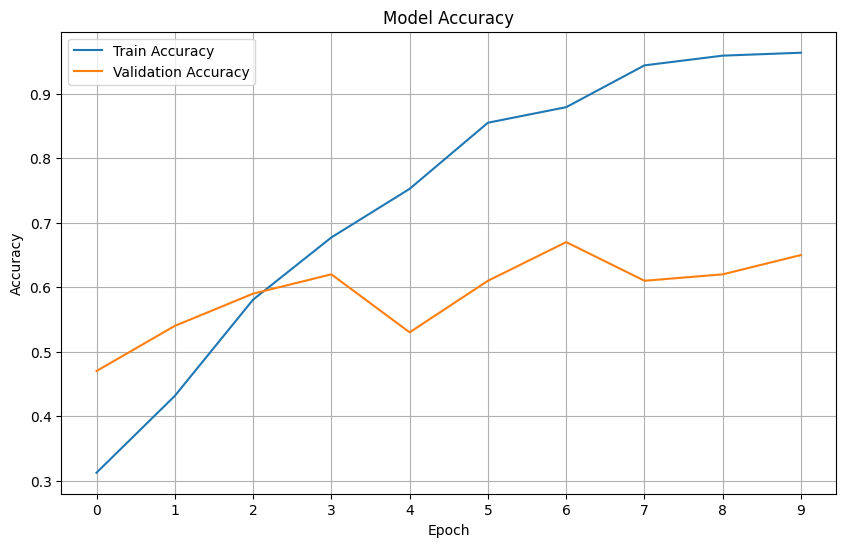

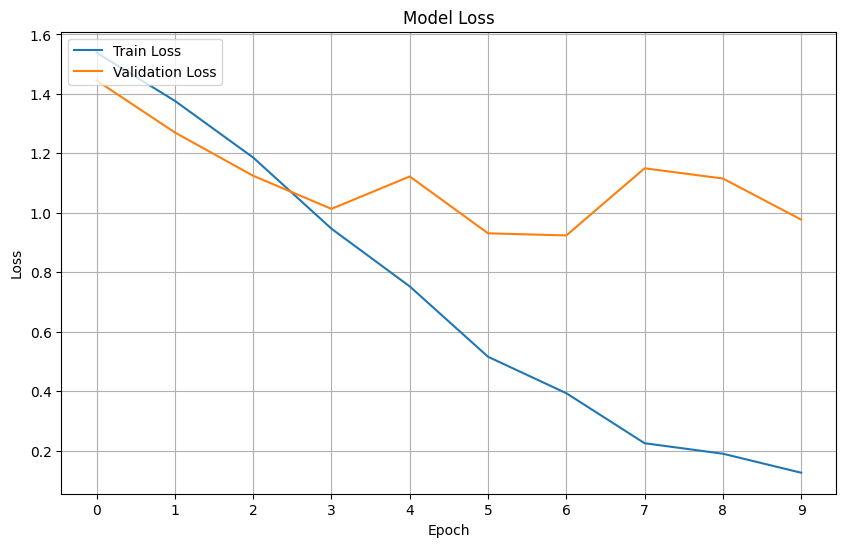


Model ID   Model Name                     Training Accuracy    Validation Accuracy 
4          build_bidirectional_lstm_model 0.9638               0.6700              

✓ GPU memory cleaned


In [22]:
models_to_train = [4]
all_results = modelutil(models_to_train=models_to_train)

✓ GPU memory cleaned

Training model 5 (build_bidirectional_gru_model)


I0000 00:00:1743445149.781691   65249 gpu_process_state.cc:208] Using CUDA malloc Async allocator for GPU: 0
I0000 00:00:1743445149.783005   65249 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 5270 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3060 Ti, pci bus id: 0000:2b:00.0, compute capability: 8.6


Model summary for model 5 (build_bidirectional_gru_model):


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 12, 112, 112,   │             0 │
│                                 │ 3)                     │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed                │ (None, 12, 112, 112,   │           896 │
│ (TimeDistributed)               │ 32)                    │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_1              │ (None, 12, 56, 56, 32) │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_2              │ (None, 12, 56, 56, 32) │           128 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_3              │ (None, 12, 56, 56, 64) │        18,496 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_4              │ (None, 12, 28, 28, 64) │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_5              │ (None, 12, 28, 28, 64) │           256 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_6              │ (None, 12, 50176)      │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 12, 128)        │    19,292,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, 64)             │        31,104 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 5)              │           645 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 19,352,773 (73.82 MB)

 Trainable params: 19,352,581 (73.82 MB)

 Non-trainable params: 192 (768.00 B)

Epoch 1/10


I0000 00:00:1743445155.033954   65494 cuda_dnn.cc:529] Loaded cuDNN version 90800


332/332 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - categorical_accuracy: 0.2751 - loss: 1.6563
Epoch 1: val_categorical_accuracy improved from -inf to 0.55000, saving model to build_bidirectional_gru_model_2025-03-3123_48_00.129217/model-01-0.5500.h5


332/332 ━━━━━━━━━━━━━━━━━━━━ 19s 42ms/step - categorical_accuracy: 0.2752 - loss: 1.6560 - val_categorical_accuracy: 0.5500 - val_loss: 1.2874 - learning_rate: 1.0000e-04
Epoch 2/10
331/332 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - categorical_accuracy: 0.5041 - loss: 1.2724
Epoch 2: val_categorical_accuracy improved from 0.55000 to 0.56000, saving model to build_bidirectional_gru_model_2025-03-3123_48_00.129217/model-02-0.5600.h5


332/332 ━━━━━━━━━━━━━━━━━━━━ 13s 39ms/step - categorical_accuracy: 0.5041 - loss: 1.2722 - val_categorical_accuracy: 0.5600 - val_loss: 1.1370 - learning_rate: 1.0000e-04
Epoch 3/10
331/332 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - categorical_accuracy: 0.6281 - loss: 1.0150
Epoch 3: val_categorical_accuracy improved from 0.56000 to 0.61000, saving model to build_bidirectional_gru_model_2025-03-3123_48_00.129217/model-03-0.6100.h5


332/332 ━━━━━━━━━━━━━━━━━━━━ 13s 39ms/step - categorical_accuracy: 0.6282 - loss: 1.0148 - val_categorical_accuracy: 0.6100 - val_loss: 0.9881 - learning_rate: 1.0000e-04
Epoch 4/10
331/332 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - categorical_accuracy: 0.7338 - loss: 0.7599
Epoch 4: val_categorical_accuracy improved from 0.61000 to 0.68000, saving model to build_bidirectional_gru_model_2025-03-3123_48_00.129217/model-04-0.6800.h5


332/332 ━━━━━━━━━━━━━━━━━━━━ 13s 39ms/step - categorical_accuracy: 0.7338 - loss: 0.7598 - val_categorical_accuracy: 0.6800 - val_loss: 0.8630 - learning_rate: 1.0000e-04
Epoch 5/10
331/332 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - categorical_accuracy: 0.8560 - loss: 0.5429
Epoch 5: val_categorical_accuracy improved from 0.68000 to 0.71000, saving model to build_bidirectional_gru_model_2025-03-3123_48_00.129217/model-05-0.7100.h5


332/332 ━━━━━━━━━━━━━━━━━━━━ 13s 39ms/step - categorical_accuracy: 0.8561 - loss: 0.5426 - val_categorical_accuracy: 0.7100 - val_loss: 0.7988 - learning_rate: 1.0000e-04
Epoch 6/10
331/332 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - categorical_accuracy: 0.9446 - loss: 0.3111
Epoch 6: val_categorical_accuracy did not improve from 0.71000
332/332 ━━━━━━━━━━━━━━━━━━━━ 12s 38ms/step - categorical_accuracy: 0.9445 - loss: 0.3111 - val_categorical_accuracy: 0.6400 - val_loss: 0.8945 - learning_rate: 1.0000e-04
Epoch 7/10
331/332 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - categorical_accuracy: 0.9849 - loss: 0.1859
Epoch 7: val_categorical_accuracy improved from 0.71000 to 0.74000, saving model to build_bidirectional_gru_model_2025-03-3123_48_00.129217/model-07-0.7400.h5


332/332 ━━━━━━━━━━━━━━━━━━━━ 13s 39ms/step - categorical_accuracy: 0.9848 - loss: 0.1859 - val_categorical_accuracy: 0.7400 - val_loss: 0.6564 - learning_rate: 1.0000e-04
Epoch 8/10
331/332 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - categorical_accuracy: 0.9944 - loss: 0.1025
Epoch 8: val_categorical_accuracy improved from 0.74000 to 0.75000, saving model to build_bidirectional_gru_model_2025-03-3123_48_00.129217/model-08-0.7500.h5


332/332 ━━━━━━━━━━━━━━━━━━━━ 13s 39ms/step - categorical_accuracy: 0.9944 - loss: 0.1024 - val_categorical_accuracy: 0.7500 - val_loss: 0.7468 - learning_rate: 1.0000e-04
Epoch 9/10
331/332 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - categorical_accuracy: 0.9979 - loss: 0.0654
Epoch 9: val_categorical_accuracy did not improve from 0.75000
332/332 ━━━━━━━━━━━━━━━━━━━━ 13s 38ms/step - categorical_accuracy: 0.9979 - loss: 0.0654 - val_categorical_accuracy: 0.7200 - val_loss: 0.8541 - learning_rate: 1.0000e-04
Epoch 10/10
331/332 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - categorical_accuracy: 1.0000 - loss: 0.0470
Epoch 10: val_categorical_accuracy did not improve from 0.75000

Epoch 10: ReduceLROnPlateau reducing learning rate to 1.9999999494757503e-05.
332/332 ━━━━━━━━━━━━━━━━━━━━ 13s 38ms/step - categorical_accuracy: 1.0000 - loss: 0.0470 - val_categorical_accuracy: 0.6800 - val_loss: 0.9194 - learning_rate: 1.0000e-04
Restoring model weights from the end of the best epoch: 7.


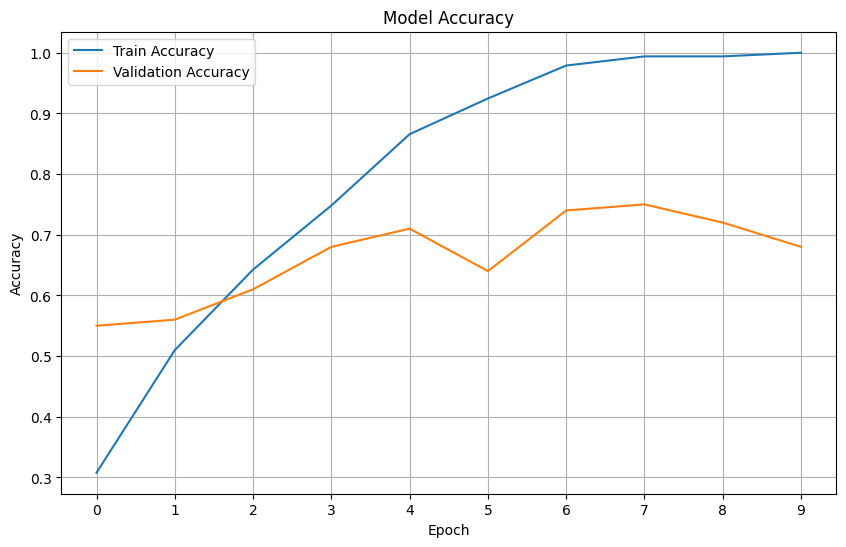

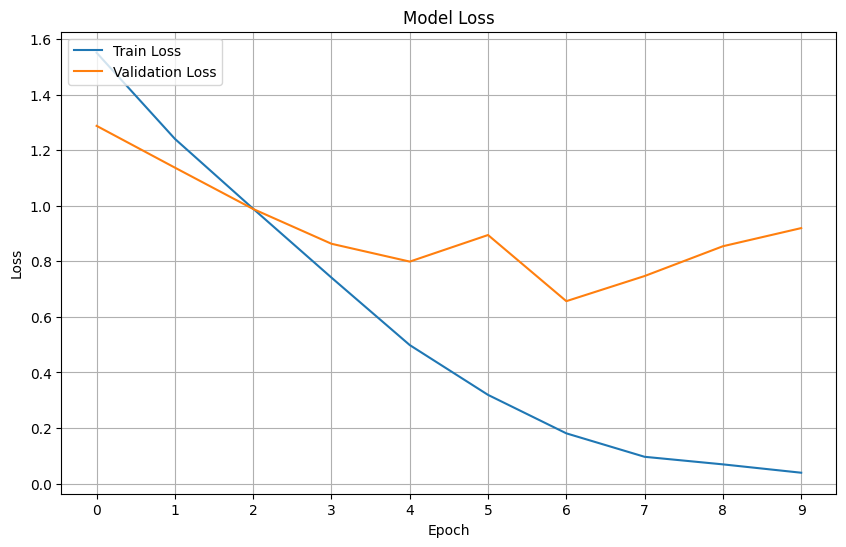


Model ID   Model Name                     Training Accuracy    Validation Accuracy 
5          build_bidirectional_gru_model  1.0000               0.7500              

✓ GPU memory cleaned


In [22]:
models_to_train = [5]
all_results = modelutil(models_to_train=models_to_train)

✓ GPU memory cleaned

Training model 6 (build_parallel_cnn_rnn_model)


I0000 00:00:1743445531.088882   67064 gpu_process_state.cc:208] Using CUDA malloc Async allocator for GPU: 0
I0000 00:00:1743445531.090093   67064 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 5275 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3060 Ti, pci bus id: 0000:2b:00.0, compute capability: 8.6


Model summary for model 6 (build_parallel_cnn_rnn_model):


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 10, 112,   │          0 │ -                 │
│ (InputLayer)        │ 112, 3)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d (Conv3D)     │ (None, 10, 112,   │      2,624 │ input_layer[0][0] │
│                     │ 112, 32)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling3d       │ (None, 10, 56,    │          0 │ conv3d[0][0]      │
│ (MaxPooling3D)      │ 56, 32)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed    │ (None, 10, 112,   │        896 │ input_layer[0][0] │
│ (TimeDistributed)   │ 112, 32)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 10, 56,    │        128 │ max_pooling3d[0]… │
│ (BatchNormalizatio… │ 56, 32)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_1  │ (None, 10, 56,    │          0 │ time_distributed… │
│ (TimeDistributed)   │ 56, 32)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d_1 (Conv3D)   │ (None, 10, 56,    │     55,360 │ batch_normalizat… │
│                     │ 56, 64)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_2  │ (None, 10, 56,    │        128 │ time_distributed… │
│ (TimeDistributed)   │ 56, 32)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling3d_1     │ (None, 10, 28,    │          0 │ conv3d_1[0][0]    │
│ (MaxPooling3D)      │ 28, 64)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_3  │ (None, 10, 32)    │          0 │ time_distributed… │
│ (TimeDistributed)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 64)        │          0 │ max_pooling3d_1[… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gru (GRU)           │ (None, 64)        │     18,816 │ time_distributed… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 128)       │          0 │ global_average_p… │
│ (Concatenate)       │                   │            │ gru[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 128)       │     16,512 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 128)       │          0 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 5)         │        645 │ dropout[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 95,109 (371.52 KB)

 Trainable params: 94,981 (371.02 KB)

 Non-trainable params: 128 (512.00 B)

Epoch 1/10


I0000 00:00:1743445534.163030   67274 cuda_dnn.cc:529] Loaded cuDNN version 90800


332/332 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - categorical_accuracy: 0.2205 - loss: 1.6209
Epoch 1: val_categorical_accuracy improved from -inf to 0.40000, saving model to build_parallel_cnn_rnn_model_2025-03-3123_54_26.936819/model-01-0.4000.h5


332/332 ━━━━━━━━━━━━━━━━━━━━ 12s 26ms/step - categorical_accuracy: 0.2206 - loss: 1.6208 - val_categorical_accuracy: 0.4000 - val_loss: 1.5433 - learning_rate: 1.0000e-04
Epoch 2/10
331/332 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - categorical_accuracy: 0.2762 - loss: 1.5442
Epoch 2: val_categorical_accuracy improved from 0.40000 to 0.47000, saving model to build_parallel_cnn_rnn_model_2025-03-3123_54_26.936819/model-02-0.4700.h5


332/332 ━━━━━━━━━━━━━━━━━━━━ 8s 24ms/step - categorical_accuracy: 0.2763 - loss: 1.5442 - val_categorical_accuracy: 0.4700 - val_loss: 1.4261 - learning_rate: 1.0000e-04
Epoch 3/10
331/332 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - categorical_accuracy: 0.2954 - loss: 1.5134
Epoch 3: val_categorical_accuracy improved from 0.47000 to 0.51000, saving model to build_parallel_cnn_rnn_model_2025-03-3123_54_26.936819/model-03-0.5100.h5


332/332 ━━━━━━━━━━━━━━━━━━━━ 8s 24ms/step - categorical_accuracy: 0.2957 - loss: 1.5131 - val_categorical_accuracy: 0.5100 - val_loss: 1.2986 - learning_rate: 1.0000e-04
Epoch 4/10
331/332 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - categorical_accuracy: 0.3989 - loss: 1.3783
Epoch 4: val_categorical_accuracy improved from 0.51000 to 0.54000, saving model to build_parallel_cnn_rnn_model_2025-03-3123_54_26.936819/model-04-0.5400.h5


332/332 ━━━━━━━━━━━━━━━━━━━━ 8s 24ms/step - categorical_accuracy: 0.3988 - loss: 1.3783 - val_categorical_accuracy: 0.5400 - val_loss: 1.2116 - learning_rate: 1.0000e-04
Epoch 5/10
331/332 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - categorical_accuracy: 0.4066 - loss: 1.3281
Epoch 5: val_categorical_accuracy did not improve from 0.54000
332/332 ━━━━━━━━━━━━━━━━━━━━ 8s 24ms/step - categorical_accuracy: 0.4067 - loss: 1.3281 - val_categorical_accuracy: 0.4900 - val_loss: 1.2198 - learning_rate: 1.0000e-04
Epoch 6/10
331/332 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - categorical_accuracy: 0.4230 - loss: 1.2902
Epoch 6: val_categorical_accuracy improved from 0.54000 to 0.59000, saving model to build_parallel_cnn_rnn_model_2025-03-3123_54_26.936819/model-06-0.5900.h5


332/332 ━━━━━━━━━━━━━━━━━━━━ 8s 24ms/step - categorical_accuracy: 0.4230 - loss: 1.2903 - val_categorical_accuracy: 0.5900 - val_loss: 1.0855 - learning_rate: 1.0000e-04
Epoch 7/10
331/332 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - categorical_accuracy: 0.4492 - loss: 1.2831
Epoch 7: val_categorical_accuracy improved from 0.59000 to 0.60000, saving model to build_parallel_cnn_rnn_model_2025-03-3123_54_26.936819/model-07-0.6000.h5


332/332 ━━━━━━━━━━━━━━━━━━━━ 8s 24ms/step - categorical_accuracy: 0.4492 - loss: 1.2829 - val_categorical_accuracy: 0.6000 - val_loss: 1.0895 - learning_rate: 1.0000e-04
Epoch 8/10
331/332 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - categorical_accuracy: 0.4425 - loss: 1.2781
Epoch 8: val_categorical_accuracy improved from 0.60000 to 0.64000, saving model to build_parallel_cnn_rnn_model_2025-03-3123_54_26.936819/model-08-0.6400.h5


332/332 ━━━━━━━━━━━━━━━━━━━━ 8s 24ms/step - categorical_accuracy: 0.4425 - loss: 1.2779 - val_categorical_accuracy: 0.6400 - val_loss: 1.0334 - learning_rate: 1.0000e-04
Epoch 9/10
331/332 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - categorical_accuracy: 0.5142 - loss: 1.1396
Epoch 9: val_categorical_accuracy did not improve from 0.64000
332/332 ━━━━━━━━━━━━━━━━━━━━ 8s 24ms/step - categorical_accuracy: 0.5140 - loss: 1.1399 - val_categorical_accuracy: 0.6400 - val_loss: 1.0010 - learning_rate: 1.0000e-04
Epoch 10/10
331/332 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - categorical_accuracy: 0.4701 - loss: 1.1853
Epoch 10: val_categorical_accuracy did not improve from 0.64000
332/332 ━━━━━━━━━━━━━━━━━━━━ 8s 24ms/step - categorical_accuracy: 0.4701 - loss: 1.1854 - val_categorical_accuracy: 0.6400 - val_loss: 0.9424 - learning_rate: 1.0000e-04
Restoring model weights from the end of the best epoch: 10.


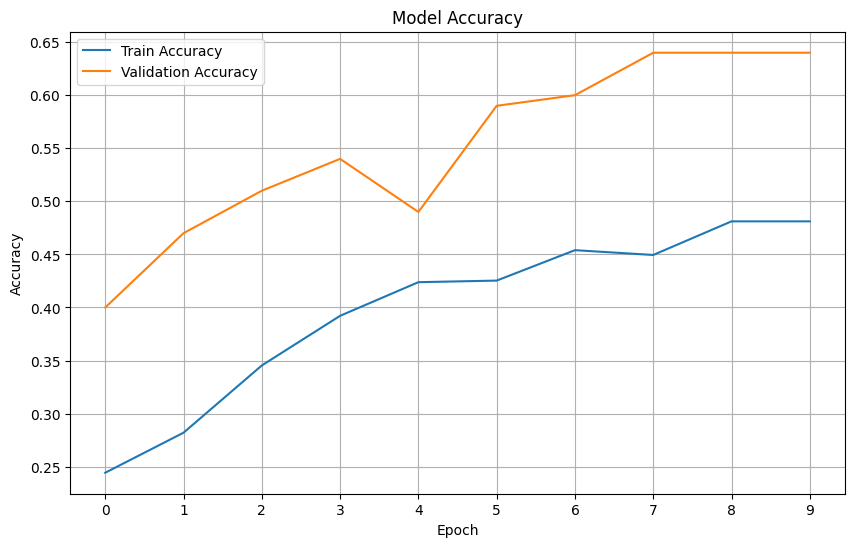

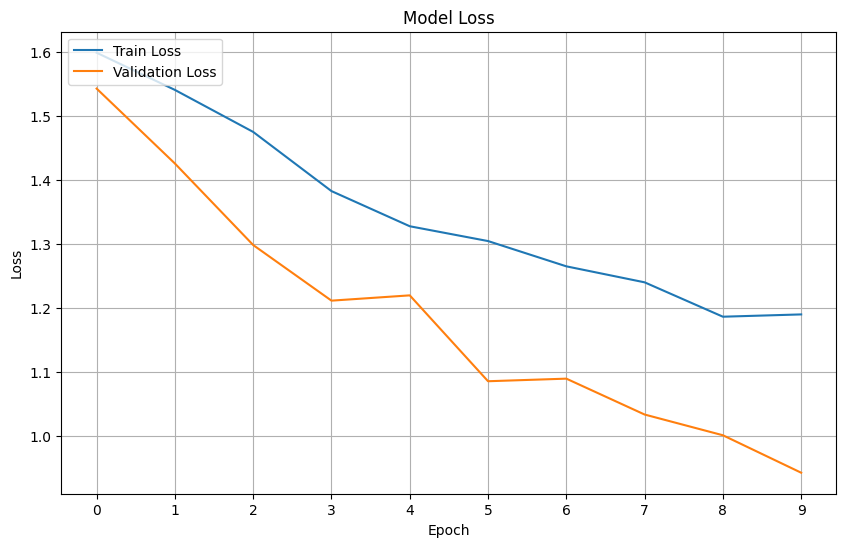


Model ID   Model Name                     Training Accuracy    Validation Accuracy 
6          build_parallel_cnn_rnn_model   0.4811               0.6400              

✓ GPU memory cleaned


In [22]:
models_to_train = [6]
all_results = modelutil(models_to_train=models_to_train)


✓ GPU memory cleaned

Training model 7 (build_conv_lstm_model)


I0000 00:00:1743445729.449793   68775 gpu_process_state.cc:208] Using CUDA malloc Async allocator for GPU: 0
I0000 00:00:1743445729.450962   68775 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 5270 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3060 Ti, pci bus id: 0000:2b:00.0, compute capability: 8.6


Model summary for model 7 (build_conv_lstm_model):


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 10, 112, 112,   │             0 │
│                                 │ 3)                     │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_lstm2d (ConvLSTM2D)        │ (None, 10, 112, 112,   │        11,008 │
│                                 │ 16)                    │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 10, 112, 112,   │            64 │
│ (BatchNormalization)            │ 16)                    │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d (MaxPooling3D)    │ (None, 10, 56, 56, 16) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_lstm2d_1 (ConvLSTM2D)      │ (None, 56, 56, 32)     │        55,424 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 56, 56, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 32)             │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │         4,224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 5)              │           645 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 71,493 (279.27 KB)

 Trainable params: 71,397 (278.89 KB)

 Non-trainable params: 96 (384.00 B)

Epoch 1/10


I0000 00:00:1743445732.016722   68985 service.cc:152] XLA service 0x1aef7f40 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1743445732.016743   68985 service.cc:160]   StreamExecutor device (0): NVIDIA GeForce RTX 3060 Ti, Compute Capability 8.6
2025-03-31 23:58:52.079552: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1743445732.445260   68985 cuda_dnn.cc:529] Loaded cuDNN version 90800


  6/332 ━━━━━━━━━━━━━━━━━━━━ 7s 23ms/step - categorical_accuracy: 0.0792 - loss: 1.6204    

2025-03-31 23:58:55.470755: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'input_add_multiply_reduce_fusion', 8 bytes spill stores, 8 bytes spill loads

I0000 00:00:1743445735.493614   68985 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


332/332 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - categorical_accuracy: 0.2177 - loss: 1.6016
Epoch 1: val_categorical_accuracy improved from -inf to 0.21000, saving model to build_conv_lstm_model_2025-03-3123_57_41.760001/model-01-0.2100.h5


332/332 ━━━━━━━━━━━━━━━━━━━━ 17s 35ms/step - categorical_accuracy: 0.2177 - loss: 1.6016 - val_categorical_accuracy: 0.2100 - val_loss: 1.5752 - learning_rate: 1.0000e-04
Epoch 2/10
330/332 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - categorical_accuracy: 0.2829 - loss: 1.5584
Epoch 2: val_categorical_accuracy improved from 0.21000 to 0.34000, saving model to build_conv_lstm_model_2025-03-3123_57_41.760001/model-02-0.3400.h5


332/332 ━━━━━━━━━━━━━━━━━━━━ 8s 24ms/step - categorical_accuracy: 0.2832 - loss: 1.5583 - val_categorical_accuracy: 0.3400 - val_loss: 1.4698 - learning_rate: 1.0000e-04
Epoch 3/10
331/332 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - categorical_accuracy: 0.3089 - loss: 1.5331
Epoch 3: val_categorical_accuracy improved from 0.34000 to 0.39000, saving model to build_conv_lstm_model_2025-03-3123_57_41.760001/model-03-0.3900.h5


332/332 ━━━━━━━━━━━━━━━━━━━━ 8s 24ms/step - categorical_accuracy: 0.3088 - loss: 1.5331 - val_categorical_accuracy: 0.3900 - val_loss: 1.4141 - learning_rate: 1.0000e-04
Epoch 4/10
331/332 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - categorical_accuracy: 0.3698 - loss: 1.4608
Epoch 4: val_categorical_accuracy did not improve from 0.39000
332/332 ━━━━━━━━━━━━━━━━━━━━ 8s 25ms/step - categorical_accuracy: 0.3697 - loss: 1.4608 - val_categorical_accuracy: 0.3700 - val_loss: 1.4308 - learning_rate: 1.0000e-04
Epoch 5/10
331/332 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - categorical_accuracy: 0.4180 - loss: 1.4122
Epoch 5: val_categorical_accuracy improved from 0.39000 to 0.49000, saving model to build_conv_lstm_model_2025-03-3123_57_41.760001/model-05-0.4900.h5


332/332 ━━━━━━━━━━━━━━━━━━━━ 8s 25ms/step - categorical_accuracy: 0.4177 - loss: 1.4123 - val_categorical_accuracy: 0.4900 - val_loss: 1.3237 - learning_rate: 1.0000e-04
Epoch 6/10
331/332 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - categorical_accuracy: 0.3638 - loss: 1.4287
Epoch 6: val_categorical_accuracy improved from 0.49000 to 0.60000, saving model to build_conv_lstm_model_2025-03-3123_57_41.760001/model-06-0.6000.h5


332/332 ━━━━━━━━━━━━━━━━━━━━ 8s 24ms/step - categorical_accuracy: 0.3639 - loss: 1.4287 - val_categorical_accuracy: 0.6000 - val_loss: 1.1219 - learning_rate: 1.0000e-04
Epoch 7/10
331/332 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - categorical_accuracy: 0.3723 - loss: 1.3958
Epoch 7: val_categorical_accuracy did not improve from 0.60000
332/332 ━━━━━━━━━━━━━━━━━━━━ 8s 24ms/step - categorical_accuracy: 0.3725 - loss: 1.3957 - val_categorical_accuracy: 0.5800 - val_loss: 1.0682 - learning_rate: 1.0000e-04
Epoch 8/10
331/332 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - categorical_accuracy: 0.3852 - loss: 1.3688
Epoch 8: val_categorical_accuracy did not improve from 0.60000
332/332 ━━━━━━━━━━━━━━━━━━━━ 8s 25ms/step - categorical_accuracy: 0.3852 - loss: 1.3689 - val_categorical_accuracy: 0.6000 - val_loss: 1.1029 - learning_rate: 1.0000e-04
Epoch 9/10
331/332 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - categorical_accuracy: 0.3947 - loss: 1.3601
Epoch 9: val_categorical_accuracy improved from 0.60000 to 0.61000,

332/332 ━━━━━━━━━━━━━━━━━━━━ 8s 24ms/step - categorical_accuracy: 0.3946 - loss: 1.3602 - val_categorical_accuracy: 0.6100 - val_loss: 1.0856 - learning_rate: 1.0000e-04
Epoch 10/10
331/332 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - categorical_accuracy: 0.4470 - loss: 1.3058
Epoch 10: val_categorical_accuracy did not improve from 0.61000
332/332 ━━━━━━━━━━━━━━━━━━━━ 8s 24ms/step - categorical_accuracy: 0.4469 - loss: 1.3059 - val_categorical_accuracy: 0.6000 - val_loss: 1.0436 - learning_rate: 1.0000e-04
Restoring model weights from the end of the best epoch: 10.


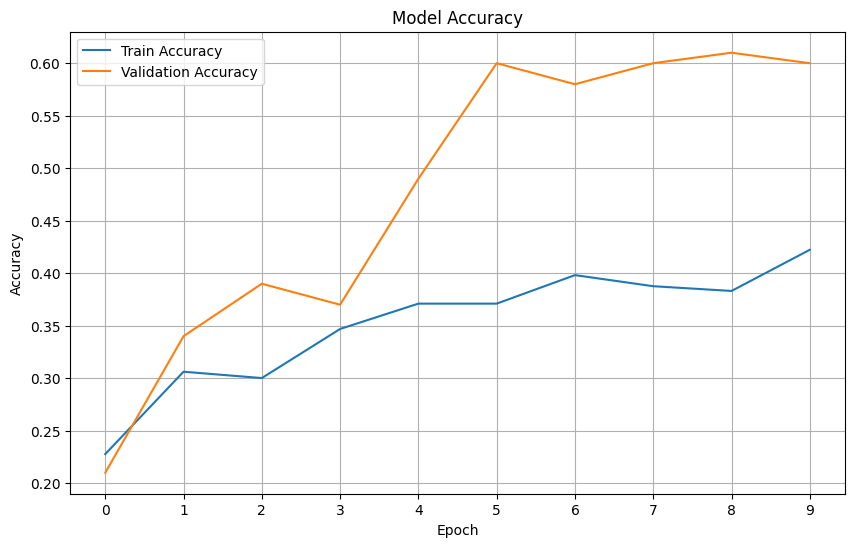

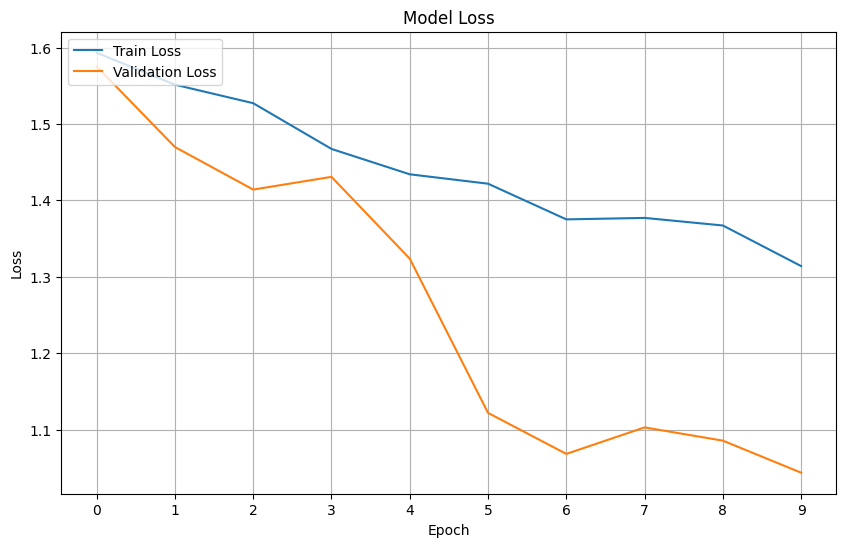


Model ID   Model Name                     Training Accuracy    Validation Accuracy 
7          build_conv_lstm_model          0.4223               0.6100              

✓ GPU memory cleaned


In [22]:
models_to_train = [7]
all_results = modelutil(models_to_train=models_to_train)

✓ GPU memory cleaned

Training model 8 (build_separable_cnn_gru_model)


I0000 00:00:1743446274.452453   70931 gpu_process_state.cc:208] Using CUDA malloc Async allocator for GPU: 0
I0000 00:00:1743446274.453648   70931 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 5195 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3060 Ti, pci bus id: 0000:2b:00.0, compute capability: 8.6


Model summary for model 8 (build_separable_cnn_gru_model):


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 12, 112, 112,   │             0 │
│                                 │ 3)                     │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed                │ (None, 12, 112, 112,   │           155 │
│ (TimeDistributed)               │ 32)                    │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_1              │ (None, 12, 56, 56, 32) │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_2              │ (None, 12, 56, 56, 32) │           128 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_3              │ (None, 12, 56, 56, 64) │         2,400 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_4              │ (None, 12, 28, 28, 64) │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_5              │ (None, 12, 28, 28, 64) │           256 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_6              │ (None, 12, 64)         │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru (GRU)                       │ (None, 128)            │        74,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 5)              │           645 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 94,592 (369.50 KB)

 Trainable params: 94,400 (368.75 KB)

 Non-trainable params: 192 (768.00 B)

Epoch 1/10


I0000 00:00:1743446279.168856   71209 cuda_dnn.cc:529] Loaded cuDNN version 90800


332/332 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - categorical_accuracy: 0.2400 - loss: 1.7212
Epoch 1: val_categorical_accuracy improved from -inf to 0.43000, saving model to build_separable_cnn_gru_model_2025-04-0100_07_08.093663/model-01-0.4300.h5


332/332 ━━━━━━━━━━━━━━━━━━━━ 16s 33ms/step - categorical_accuracy: 0.2400 - loss: 1.7211 - val_categorical_accuracy: 0.4300 - val_loss: 1.5746 - learning_rate: 1.0000e-04
Epoch 2/10
331/332 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - categorical_accuracy: 0.3248 - loss: 1.6282
Epoch 2: val_categorical_accuracy improved from 0.43000 to 0.47000, saving model to build_separable_cnn_gru_model_2025-04-0100_07_08.093663/model-02-0.4700.h5


332/332 ━━━━━━━━━━━━━━━━━━━━ 10s 30ms/step - categorical_accuracy: 0.3248 - loss: 1.6281 - val_categorical_accuracy: 0.4700 - val_loss: 1.4307 - learning_rate: 1.0000e-04
Epoch 3/10
331/332 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - categorical_accuracy: 0.3130 - loss: 1.6190
Epoch 3: val_categorical_accuracy did not improve from 0.47000
332/332 ━━━━━━━━━━━━━━━━━━━━ 10s 30ms/step - categorical_accuracy: 0.3131 - loss: 1.6188 - val_categorical_accuracy: 0.4600 - val_loss: 1.4243 - learning_rate: 1.0000e-04
Epoch 4/10
331/332 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - categorical_accuracy: 0.3537 - loss: 1.5347
Epoch 4: val_categorical_accuracy improved from 0.47000 to 0.59000, saving model to build_separable_cnn_gru_model_2025-04-0100_07_08.093663/model-04-0.5900.h5


332/332 ━━━━━━━━━━━━━━━━━━━━ 10s 30ms/step - categorical_accuracy: 0.3538 - loss: 1.5348 - val_categorical_accuracy: 0.5900 - val_loss: 1.2768 - learning_rate: 1.0000e-04
Epoch 5/10
330/332 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - categorical_accuracy: 0.3106 - loss: 1.5172
Epoch 5: val_categorical_accuracy did not improve from 0.59000
332/332 ━━━━━━━━━━━━━━━━━━━━ 10s 30ms/step - categorical_accuracy: 0.3109 - loss: 1.5173 - val_categorical_accuracy: 0.5400 - val_loss: 1.2647 - learning_rate: 1.0000e-04
Epoch 6/10
331/332 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - categorical_accuracy: 0.3558 - loss: 1.5367
Epoch 6: val_categorical_accuracy improved from 0.59000 to 0.65000, saving model to build_separable_cnn_gru_model_2025-04-0100_07_08.093663/model-06-0.6500.h5


332/332 ━━━━━━━━━━━━━━━━━━━━ 10s 30ms/step - categorical_accuracy: 0.3558 - loss: 1.5367 - val_categorical_accuracy: 0.6500 - val_loss: 1.2050 - learning_rate: 1.0000e-04
Epoch 7/10
330/332 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - categorical_accuracy: 0.3809 - loss: 1.5054
Epoch 7: val_categorical_accuracy did not improve from 0.65000
332/332 ━━━━━━━━━━━━━━━━━━━━ 10s 30ms/step - categorical_accuracy: 0.3811 - loss: 1.5053 - val_categorical_accuracy: 0.6000 - val_loss: 1.2002 - learning_rate: 1.0000e-04
Epoch 8/10
330/332 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - categorical_accuracy: 0.3680 - loss: 1.4828
Epoch 8: val_categorical_accuracy did not improve from 0.65000
332/332 ━━━━━━━━━━━━━━━━━━━━ 10s 30ms/step - categorical_accuracy: 0.3680 - loss: 1.4828 - val_categorical_accuracy: 0.5800 - val_loss: 1.2205 - learning_rate: 1.0000e-04
Epoch 9/10
330/332 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - categorical_accuracy: 0.4510 - loss: 1.4257
Epoch 9: val_categorical_accuracy did not improve from 0.65000
3

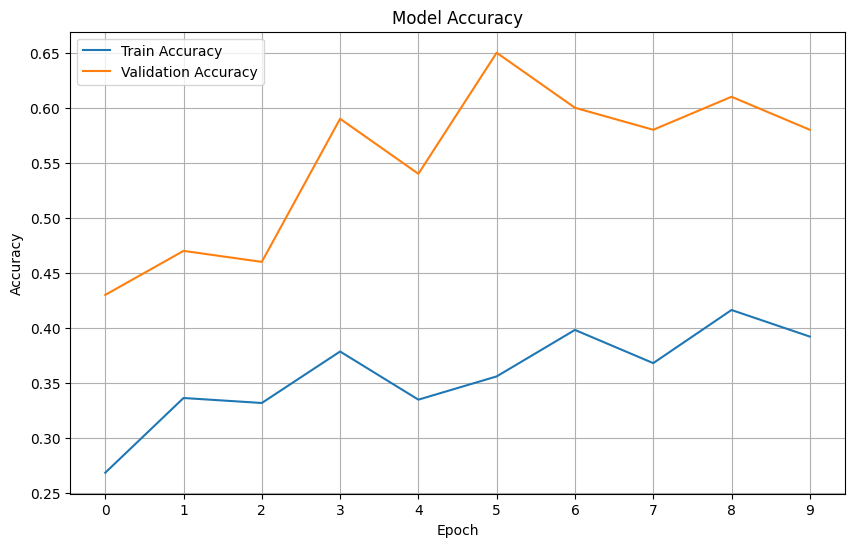

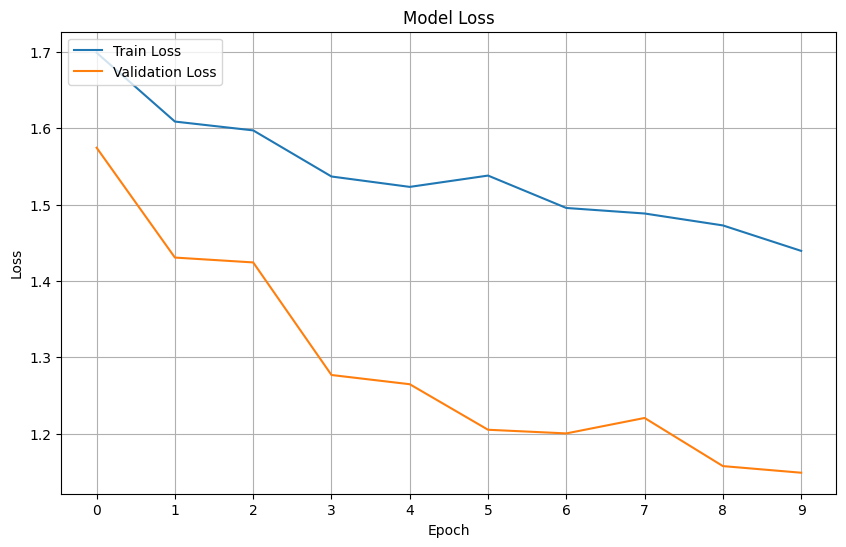


Model ID   Model Name                     Training Accuracy    Validation Accuracy 
8          build_separable_cnn_gru_model  0.4163               0.6500              

✓ GPU memory cleaned


In [22]:
models_to_train = [8]
all_results = modelutil(models_to_train=models_to_train)

✓ GPU memory cleaned

Training model 9 (build_cnn_gru_model_v2)


I0000 00:00:1743446452.073799   72725 gpu_process_state.cc:208] Using CUDA malloc Async allocator for GPU: 0
I0000 00:00:1743446452.074997   72725 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 5172 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3060 Ti, pci bus id: 0000:2b:00.0, compute capability: 8.6


Model summary for model 9 (build_cnn_gru_model_v2):


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 12, 112, 112,   │             0 │
│                                 │ 3)                     │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed                │ (None, 12, 112, 112,   │           896 │
│ (TimeDistributed)               │ 32)                    │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_1              │ (None, 12, 56, 56, 32) │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_2              │ (None, 12, 56, 56, 32) │           128 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_3              │ (None, 12, 56, 56, 64) │        18,496 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_4              │ (None, 12, 28, 28, 64) │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_5              │ (None, 12, 28, 28, 64) │           256 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_6              │ (None, 12, 50176)      │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru (GRU)                       │ (None, 128)            │    19,317,504 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 5)              │         1,285 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 19,371,589 (73.90 MB)

 Trainable params: 19,371,397 (73.90 MB)

 Non-trainable params: 192 (768.00 B)

Epoch 1/15


I0000 00:00:1743446456.594417   72944 cuda_dnn.cc:529] Loaded cuDNN version 90800


332/332 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - categorical_accuracy: 0.2449 - loss: 1.8141
Epoch 1: val_categorical_accuracy improved from -inf to 0.53000, saving model to build_cnn_gru_model_v2_2025-04-0100_10_07.666834/model-01-0.5300.h5


332/332 ━━━━━━━━━━━━━━━━━━━━ 19s 41ms/step - categorical_accuracy: 0.2450 - loss: 1.8138 - val_categorical_accuracy: 0.5300 - val_loss: 1.3652 - learning_rate: 1.0000e-04
Epoch 2/15
332/332 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - categorical_accuracy: 0.4826 - loss: 1.4032
Epoch 2: val_categorical_accuracy did not improve from 0.53000
332/332 ━━━━━━━━━━━━━━━━━━━━ 13s 38ms/step - categorical_accuracy: 0.4826 - loss: 1.4032 - val_categorical_accuracy: 0.5000 - val_loss: 1.2289 - learning_rate: 1.0000e-04
Epoch 3/15
331/332 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - categorical_accuracy: 0.5083 - loss: 1.2928
Epoch 3: val_categorical_accuracy improved from 0.53000 to 0.57000, saving model to build_cnn_gru_model_v2_2025-04-0100_10_07.666834/model-03-0.5700.h5


332/332 ━━━━━━━━━━━━━━━━━━━━ 13s 38ms/step - categorical_accuracy: 0.5083 - loss: 1.2927 - val_categorical_accuracy: 0.5700 - val_loss: 1.1936 - learning_rate: 1.0000e-04
Epoch 4/15
331/332 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - categorical_accuracy: 0.6391 - loss: 1.0813
Epoch 4: val_categorical_accuracy improved from 0.57000 to 0.61000, saving model to build_cnn_gru_model_v2_2025-04-0100_10_07.666834/model-04-0.6100.h5


332/332 ━━━━━━━━━━━━━━━━━━━━ 13s 38ms/step - categorical_accuracy: 0.6391 - loss: 1.0812 - val_categorical_accuracy: 0.6100 - val_loss: 1.0871 - learning_rate: 1.0000e-04
Epoch 5/15
331/332 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - categorical_accuracy: 0.7461 - loss: 0.8487
Epoch 5: val_categorical_accuracy improved from 0.61000 to 0.62000, saving model to build_cnn_gru_model_v2_2025-04-0100_10_07.666834/model-05-0.6200.h5


332/332 ━━━━━━━━━━━━━━━━━━━━ 13s 38ms/step - categorical_accuracy: 0.7461 - loss: 0.8487 - val_categorical_accuracy: 0.6200 - val_loss: 1.0537 - learning_rate: 1.0000e-04
Epoch 6/15
331/332 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - categorical_accuracy: 0.8132 - loss: 0.6753
Epoch 6: val_categorical_accuracy improved from 0.62000 to 0.71000, saving model to build_cnn_gru_model_v2_2025-04-0100_10_07.666834/model-06-0.7100.h5


332/332 ━━━━━━━━━━━━━━━━━━━━ 13s 38ms/step - categorical_accuracy: 0.8131 - loss: 0.6754 - val_categorical_accuracy: 0.7100 - val_loss: 0.9769 - learning_rate: 1.0000e-04
Epoch 7/15
331/332 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - categorical_accuracy: 0.8771 - loss: 0.5492
Epoch 7: val_categorical_accuracy improved from 0.71000 to 0.77000, saving model to build_cnn_gru_model_v2_2025-04-0100_10_07.666834/model-07-0.7700.h5


332/332 ━━━━━━━━━━━━━━━━━━━━ 13s 38ms/step - categorical_accuracy: 0.8771 - loss: 0.5491 - val_categorical_accuracy: 0.7700 - val_loss: 0.8703 - learning_rate: 1.0000e-04
Epoch 8/15
331/332 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - categorical_accuracy: 0.9346 - loss: 0.4169
Epoch 8: val_categorical_accuracy did not improve from 0.77000
332/332 ━━━━━━━━━━━━━━━━━━━━ 12s 37ms/step - categorical_accuracy: 0.9346 - loss: 0.4169 - val_categorical_accuracy: 0.6800 - val_loss: 0.9109 - learning_rate: 1.0000e-04
Epoch 9/15
331/332 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - categorical_accuracy: 0.9641 - loss: 0.2970
Epoch 9: val_categorical_accuracy did not improve from 0.77000
332/332 ━━━━━━━━━━━━━━━━━━━━ 12s 37ms/step - categorical_accuracy: 0.9641 - loss: 0.2971 - val_categorical_accuracy: 0.7100 - val_loss: 0.9345 - learning_rate: 1.0000e-04
Epoch 10/15
331/332 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - categorical_accuracy: 0.9557 - loss: 0.2924
Epoch 10: val_categorical_accuracy did not improve from 0.77000

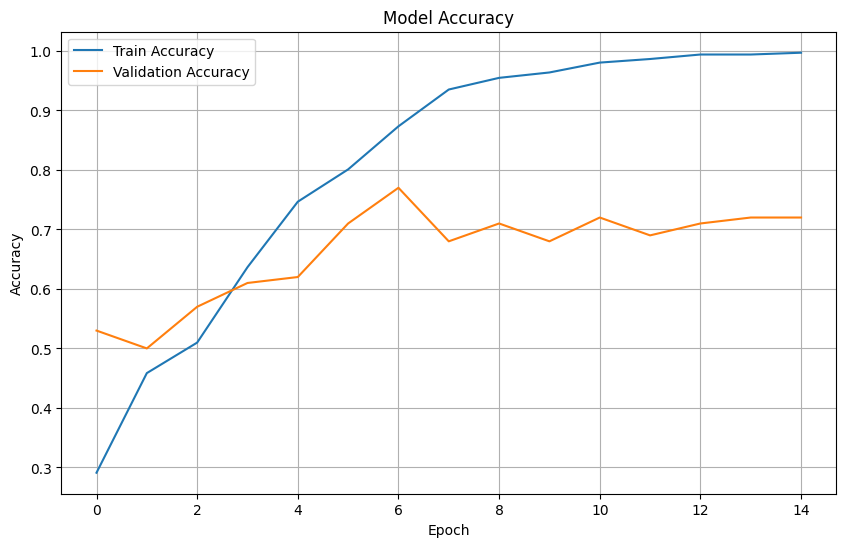

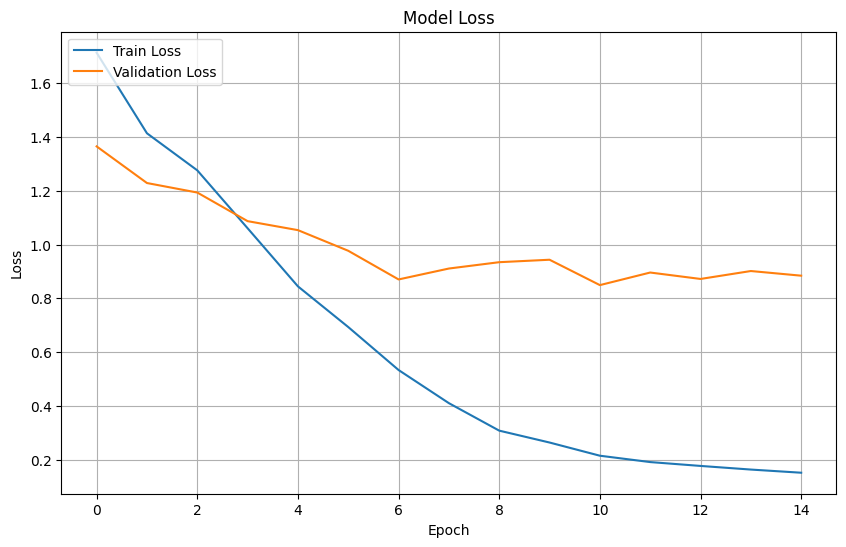


Model ID   Model Name                     Training Accuracy    Validation Accuracy 
9          build_cnn_gru_model_v2         0.9970               0.7700              

✓ GPU memory cleaned


In [22]:
models_to_train = [9]
all_results = modelutil(models_to_train=models_to_train, num_epochs=15)

build_cnn_gru_model : Integrated a CNN with Batch Normalization, increased the number of frames per video sample, and extended training epochs.
These enhancements improved feature extraction and generalization, leading to higher training and validation accuracy in gesture recognition.